In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_polution_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [4]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [5]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


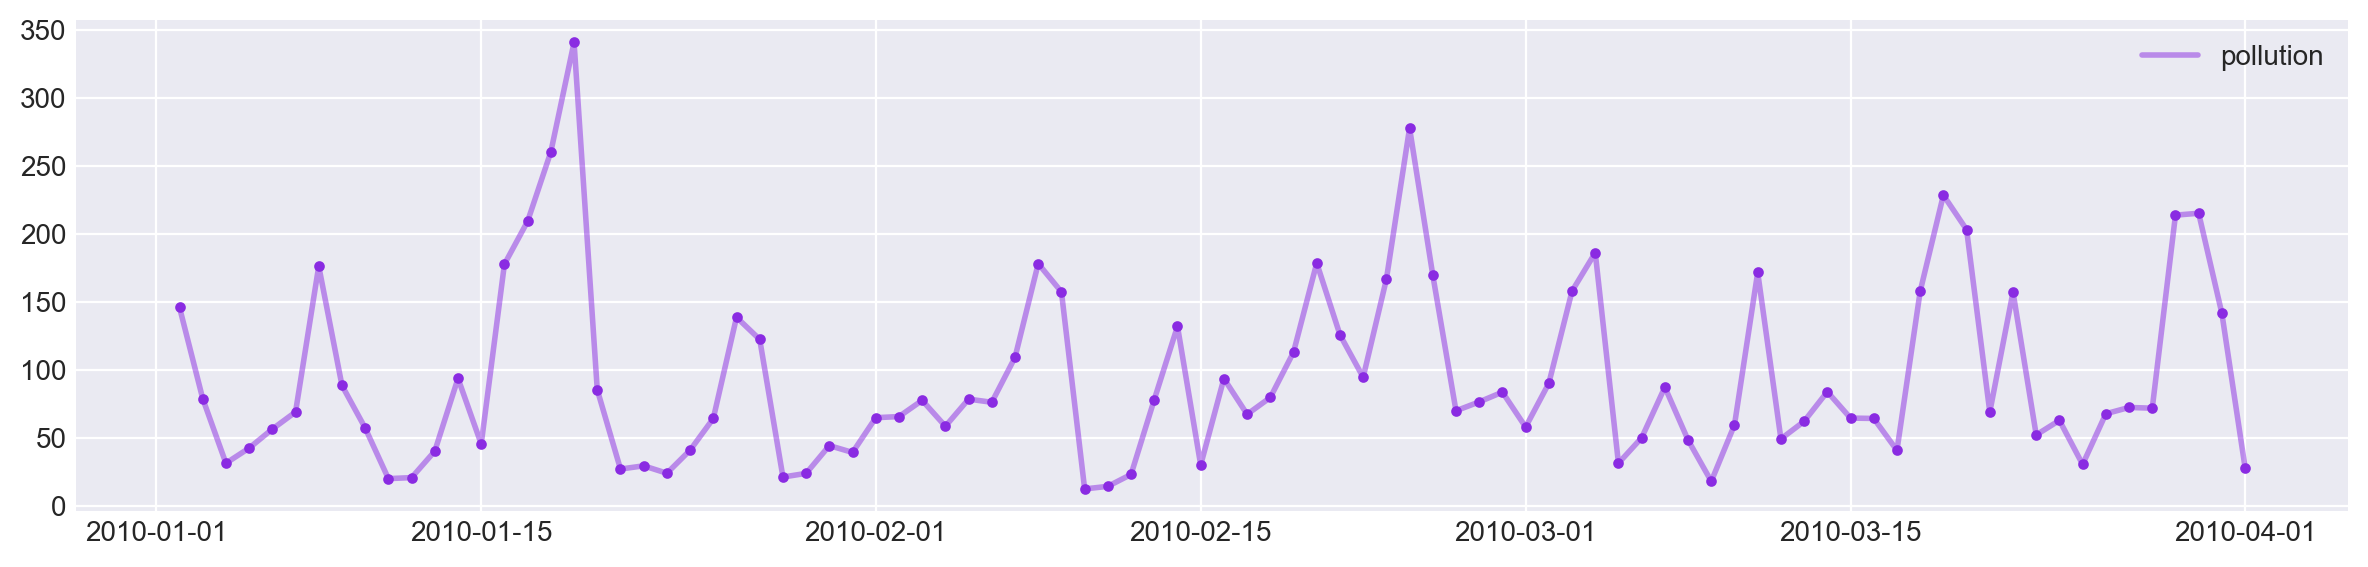

In [6]:
show_dataset(dataframe[:90], columns=["pollution"])

In [7]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "pollution"
TEST_SIZE = 30

In [8]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (1795, 7)
Test  Size after Test_Train Split: (30, 7) 
train_data shape after Feature Union (1795, 26)
test_data shape after Feature Union (30, 26)
train_data shape after Null Removal (1793, 26)
test_data shape after Null Removal (30, 26)


,pollution,dewp,temp,press,wnd_spd,snow,rain,pollution_lag_1,pollution_lag_2,pollution_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date,,,,,,,,,,,,,,,,,,,,,
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,38.071250,0.0,0.0,51.791667,51.791667,28.791667,...,2.0,49.0,0.0,1.0,0.909297,-0.416147,-0.536573,0.843854,0.149847,-0.988709
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,53.080417,0.0,0.0,51.791667,51.791667,28.791667,...,3.0,49.0,0.0,1.0,0.141120,-0.989992,-0.536573,0.843854,-0.751007,-0.660294
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,60.924583,0.0,0.0,25.375000,51.791667,28.791667,...,4.0,49.0,0.0,1.0,-0.756802,-0.653644,-0.536573,0.843854,-0.961389,0.275192
2014-12-05,36.375000,-20.250000,-2.750000,1027.208333,14.563333,0.0,0.0,9.208333,25.375000,23.652778,...,5.0,49.0,0.0,0.0,-0.958924,0.283662,-0.536573,0.843854,-0.287874,0.957668
2014-12-06,70.541667,-16.541667,-1.958333,1026.291667,4.210833,0.0,0.0,36.375000,9.208333,38.708333,...,6.0,49.0,1.0,0.0,-0.279415,0.960170,-0.536573,0.843854,0.650311,0.759668


In [9]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.107 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.293 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.430 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.147 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.389 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.457 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.238 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.374 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.484 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.272 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.366 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

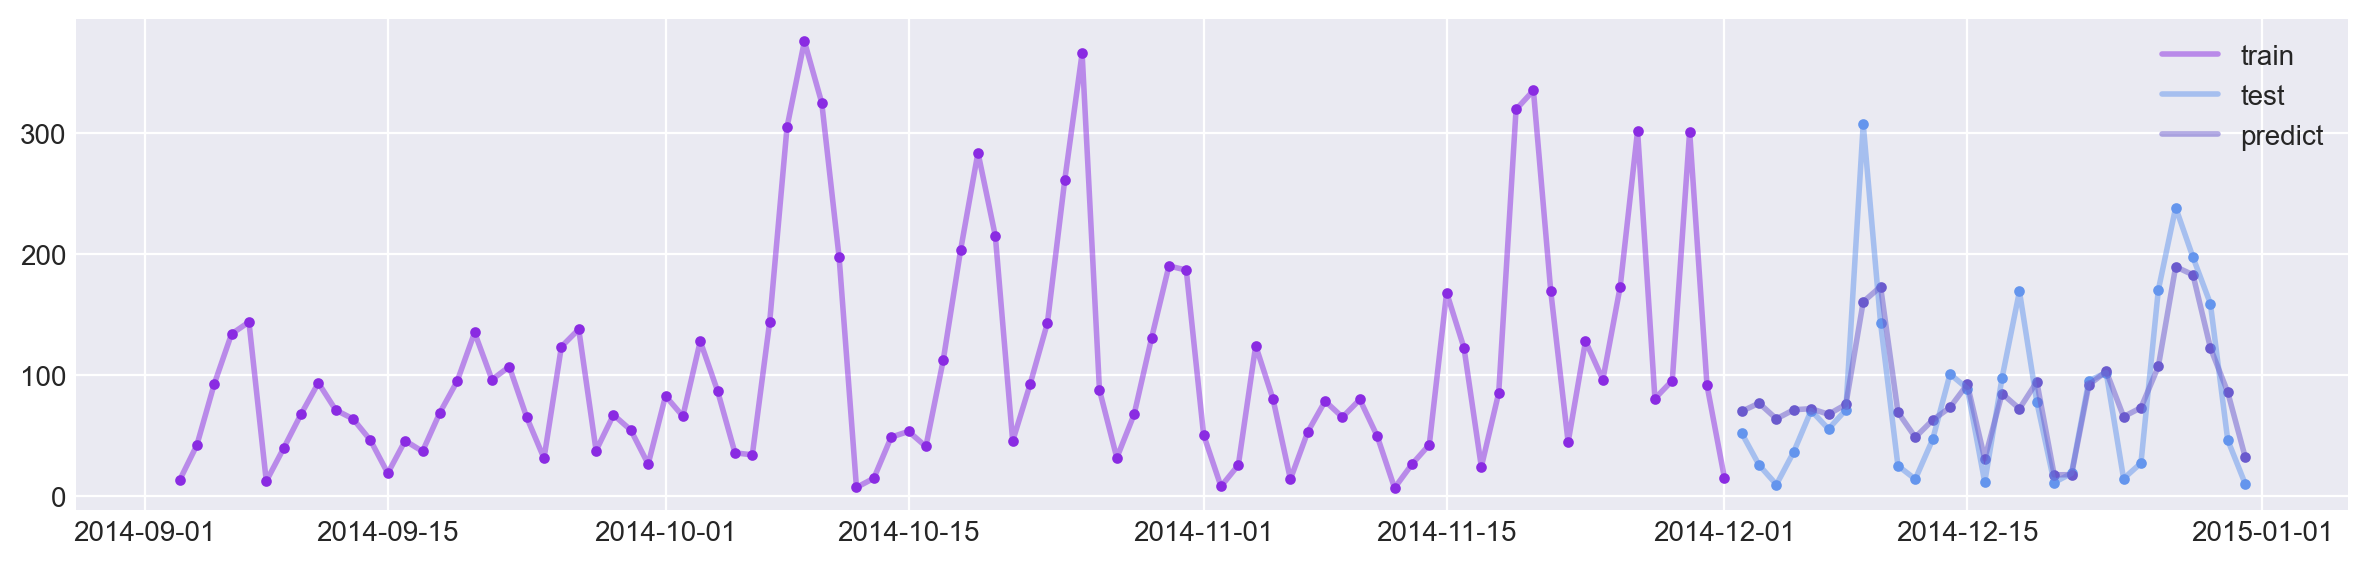

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [13]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


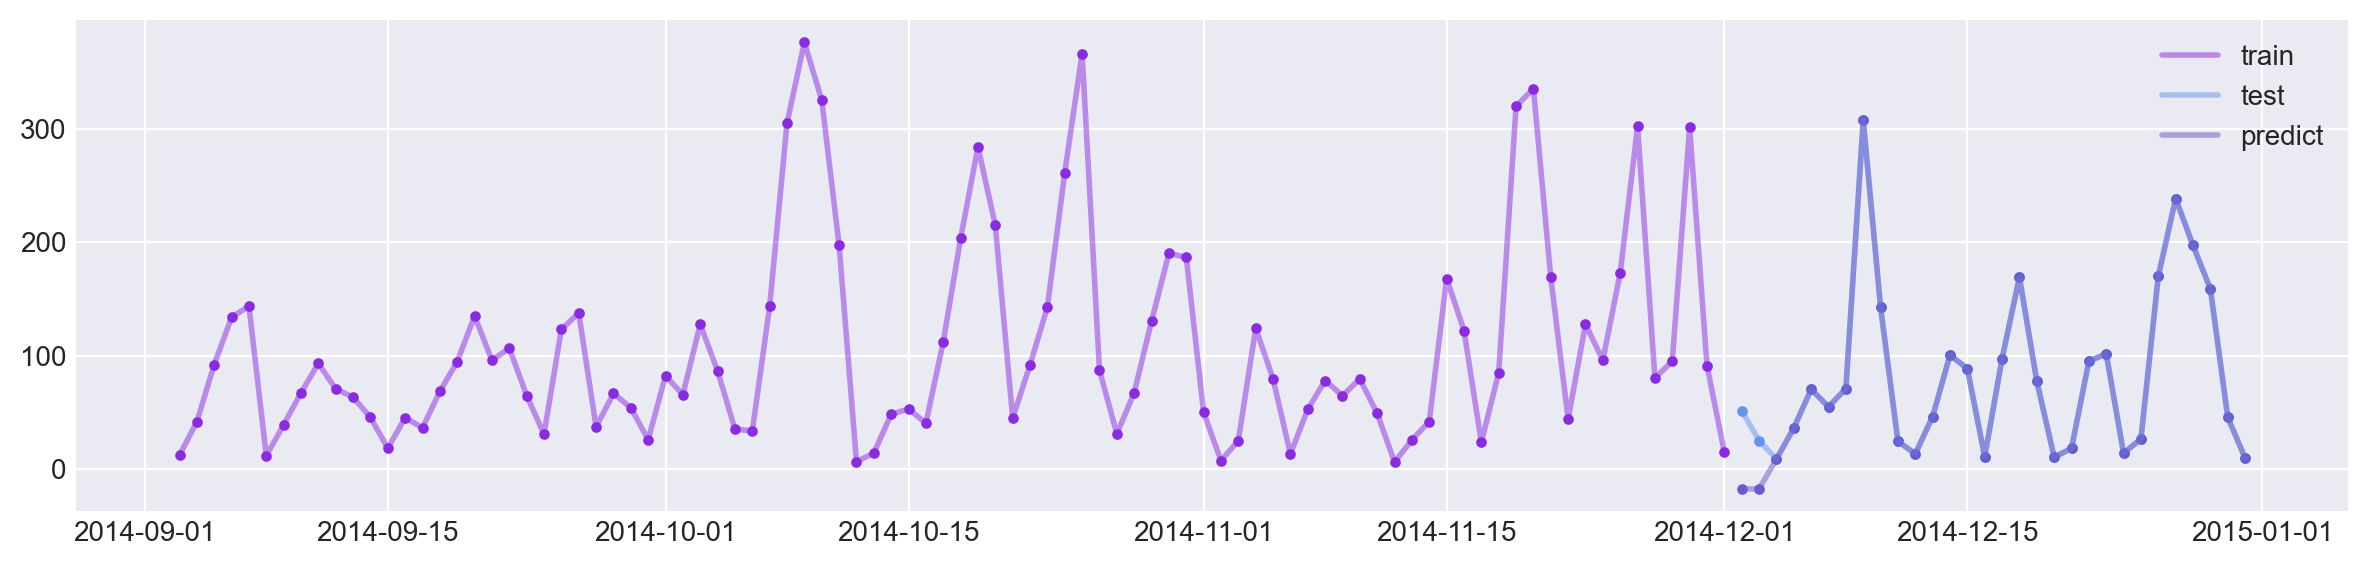

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [15]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

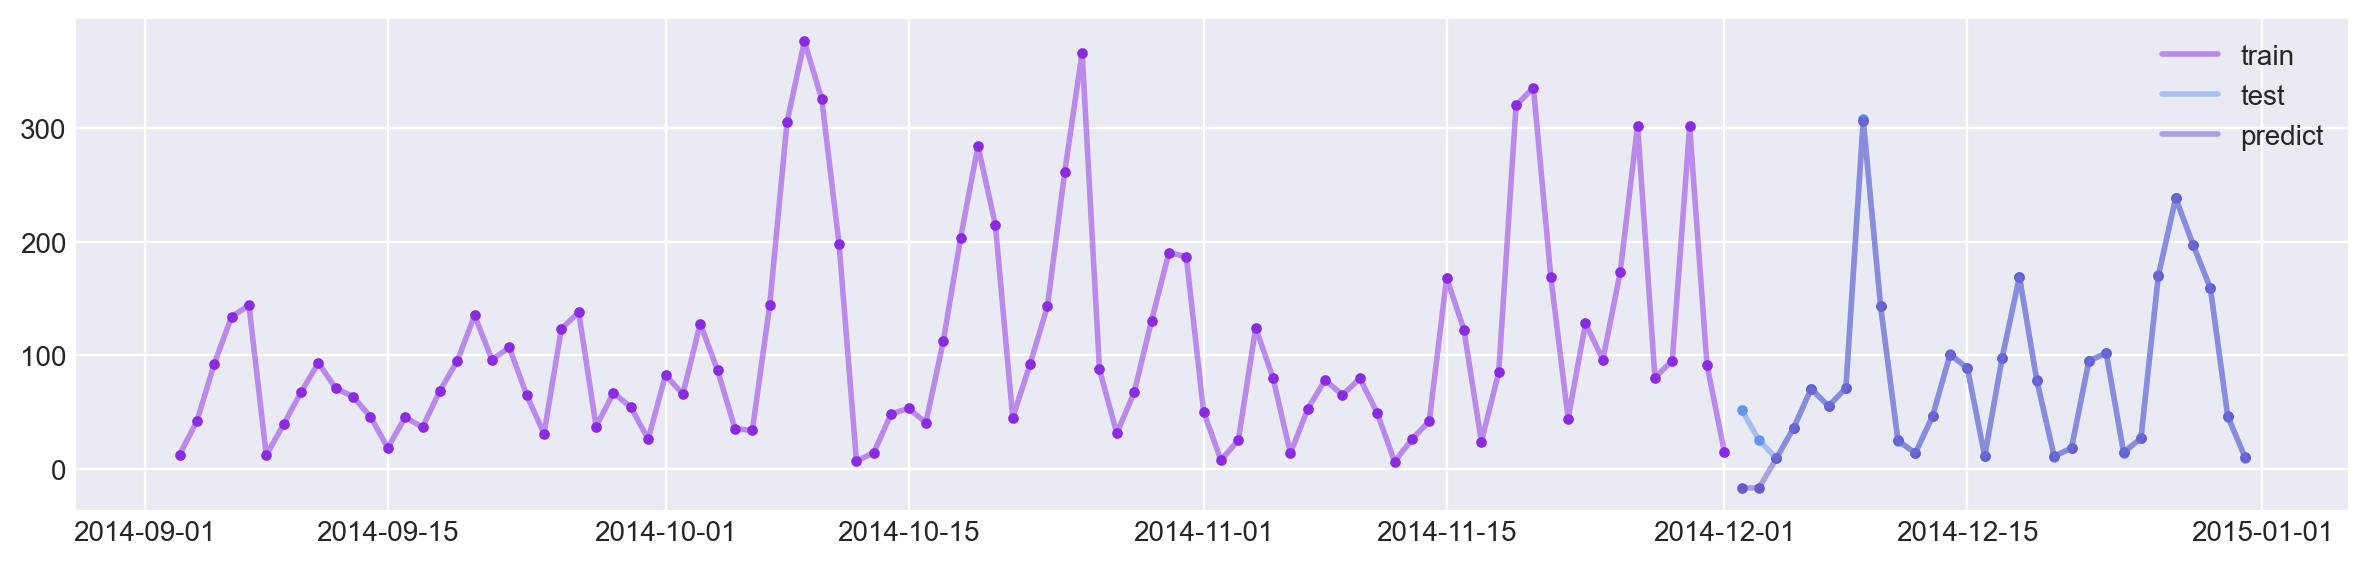

In [16]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

param_grid = {
    #'bootstrap': [True,False],
    "max_depth": [7, 8, 9],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [7, 8],
    "n_estimators": [300, 500, 600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.812 total time=   1.1s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.867 total time=   2.3s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.916 total time=   3.1s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.814 total time=   1.7s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.867 total time=   3.7s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.917 total time=   5.2s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.814 total time=   2.2s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.867 total time=   4.9s
[C

[CV 2/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.872 total time=   5.1s
[CV 3/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.923 total time=   7.5s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.820 total time=   1.5s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.880 total time=   4.0s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.930 total time=  41.8s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.823 total time=  18.5s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.880 total time=  31.4s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.930 total time=  56.9s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=

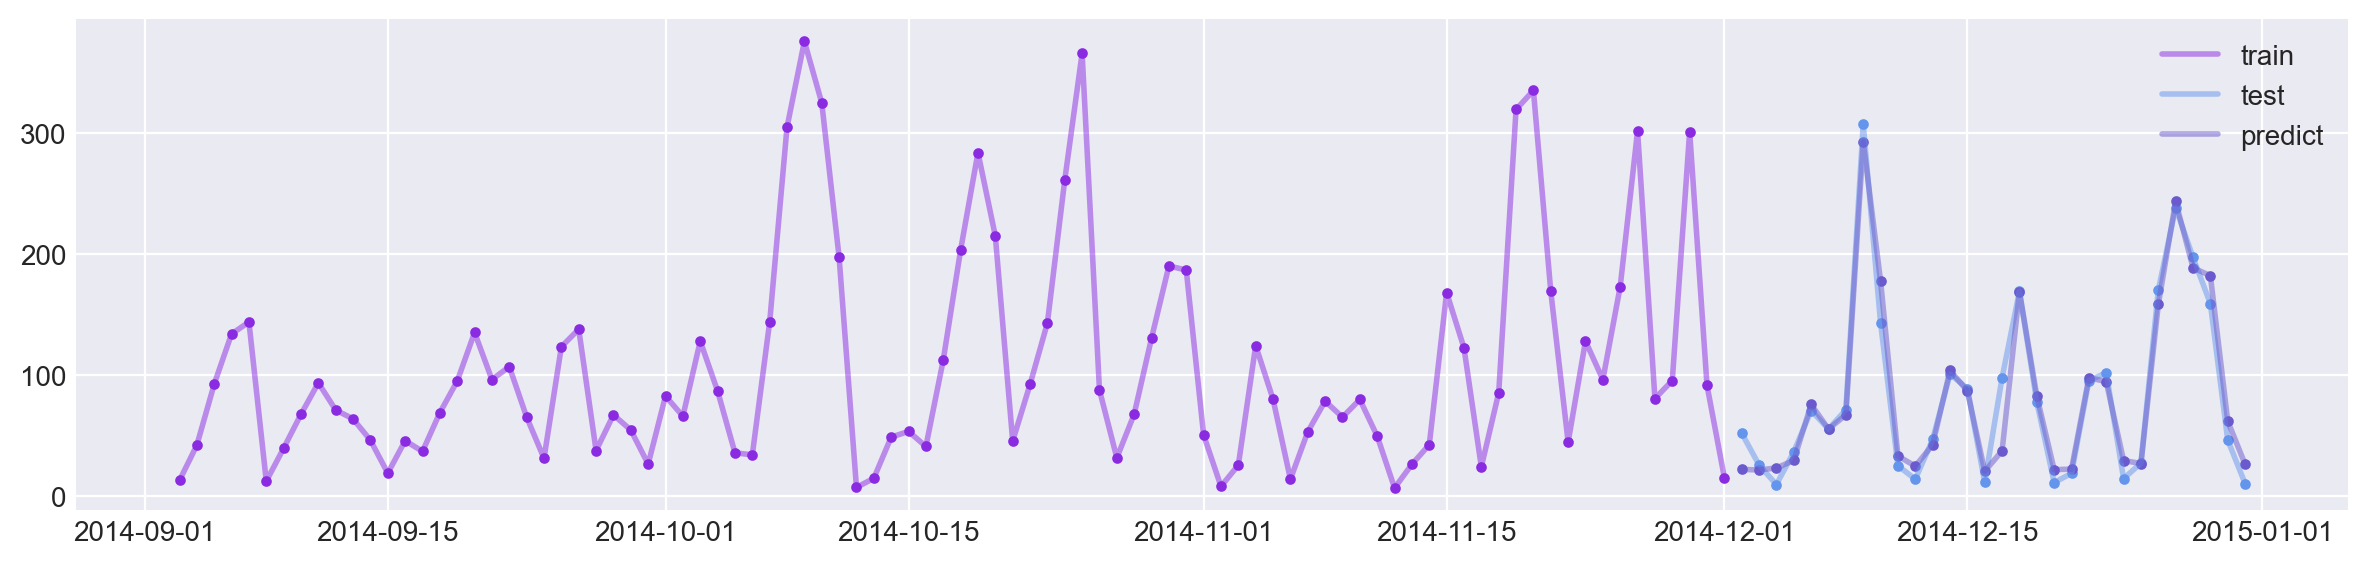

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:97.02985	validation_1-mae:81.73658
[1]	validation_0-mae:96.08425	validation_1-mae:80.98079
[2]	validation_0-mae:95.14682	validation_1-mae:80.20623
[3]	validation_0-mae:94.21994	validation_1-mae:79.47328
[4]	validation_0-mae:93.30037	validation_1-mae:78.71389
[5]	validation_0-mae:92.39062	validation_1-mae:77.94632
[6]	validation_0-mae:91.49137	validation_1-mae:77.21522
[7]	validation_0-mae:90.59839	validation_1-mae:76.43074
[8]	validation_0-mae:89.71562	validation_1-mae:75.67111
[9]	validation_0-mae:88.84196	validation_1-mae:74.97567
[10]	validation_0-mae:87.97741	validation_1-mae:74.26683
[11]	validation_0-mae:87.11801	validation_1-mae:73.55352
[12]	validation_0-mae:86.26645	validation_1-mae:72.91540
[13]	validation_0-mae:85.42854	validation_1-mae:72.28067
[14]	validation_0-mae:84.59440	validation_1-mae:71.56677
[15]	validation_0-mae:83.76860	validation_1-mae:70.95229
[16]	validation_0-mae:82.95129	validation_1-mae:70.24675
[17]	validation_0-mae:82.14500	validation

[144]	validation_0-mae:24.92815	validation_1-mae:25.60369
[145]	validation_0-mae:24.71296	validation_1-mae:25.41903
[146]	validation_0-mae:24.49865	validation_1-mae:25.20772
[147]	validation_0-mae:24.29099	validation_1-mae:25.03550
[148]	validation_0-mae:24.08353	validation_1-mae:24.84437
[149]	validation_0-mae:23.87090	validation_1-mae:24.66376
[150]	validation_0-mae:23.67053	validation_1-mae:24.51696
[151]	validation_0-mae:23.46764	validation_1-mae:24.34557
[152]	validation_0-mae:23.26609	validation_1-mae:24.18977
[153]	validation_0-mae:23.06213	validation_1-mae:24.01883
[154]	validation_0-mae:22.86209	validation_1-mae:23.85105
[155]	validation_0-mae:22.67257	validation_1-mae:23.70180
[156]	validation_0-mae:22.48038	validation_1-mae:23.53076
[157]	validation_0-mae:22.29158	validation_1-mae:23.35948
[158]	validation_0-mae:22.10188	validation_1-mae:23.20077
[159]	validation_0-mae:21.91171	validation_1-mae:23.05605
[160]	validation_0-mae:21.72633	validation_1-mae:22.89443
[161]	validati

[286]	validation_0-mae:8.61212	validation_1-mae:12.16357
[287]	validation_0-mae:8.56301	validation_1-mae:12.12068
[288]	validation_0-mae:8.51342	validation_1-mae:12.07405
[289]	validation_0-mae:8.46260	validation_1-mae:12.04132
[290]	validation_0-mae:8.41454	validation_1-mae:12.00448
[291]	validation_0-mae:8.36808	validation_1-mae:11.97180
[292]	validation_0-mae:8.31990	validation_1-mae:11.93387
[293]	validation_0-mae:8.27261	validation_1-mae:11.89777
[294]	validation_0-mae:8.22290	validation_1-mae:11.88565
[295]	validation_0-mae:8.17537	validation_1-mae:11.86111
[296]	validation_0-mae:8.12855	validation_1-mae:11.82927
[297]	validation_0-mae:8.07889	validation_1-mae:11.80607
[298]	validation_0-mae:8.03398	validation_1-mae:11.77434
[299]	validation_0-mae:7.98862	validation_1-mae:11.74006
[300]	validation_0-mae:7.94389	validation_1-mae:11.70989
[301]	validation_0-mae:7.90003	validation_1-mae:11.67714
[302]	validation_0-mae:7.85545	validation_1-mae:11.64937
[303]	validation_0-mae:7.81252	

[431]	validation_0-mae:4.43280	validation_1-mae:9.75958
[432]	validation_0-mae:4.41979	validation_1-mae:9.75170
[433]	validation_0-mae:4.40537	validation_1-mae:9.74763
[434]	validation_0-mae:4.38986	validation_1-mae:9.73893
[435]	validation_0-mae:4.37368	validation_1-mae:9.72814
[436]	validation_0-mae:4.35795	validation_1-mae:9.73055
[437]	validation_0-mae:4.34241	validation_1-mae:9.71870
[438]	validation_0-mae:4.32773	validation_1-mae:9.70846
[439]	validation_0-mae:4.31405	validation_1-mae:9.70149
[440]	validation_0-mae:4.30131	validation_1-mae:9.69415
[441]	validation_0-mae:4.28769	validation_1-mae:9.68596
[442]	validation_0-mae:4.27415	validation_1-mae:9.67784
[443]	validation_0-mae:4.25905	validation_1-mae:9.66351
[444]	validation_0-mae:4.24448	validation_1-mae:9.66414
[445]	validation_0-mae:4.22960	validation_1-mae:9.64874
[446]	validation_0-mae:4.21726	validation_1-mae:9.64197
[447]	validation_0-mae:4.20323	validation_1-mae:9.63660
[448]	validation_0-mae:4.18979	validation_1-mae:

[578]	validation_0-mae:3.09300	validation_1-mae:9.20769
[579]	validation_0-mae:3.08821	validation_1-mae:9.20635
[580]	validation_0-mae:3.08438	validation_1-mae:9.20655
[581]	validation_0-mae:3.07918	validation_1-mae:9.20738
[582]	validation_0-mae:3.07603	validation_1-mae:9.20418
[583]	validation_0-mae:3.07157	validation_1-mae:9.20198
[584]	validation_0-mae:3.06806	validation_1-mae:9.20022
[585]	validation_0-mae:3.06302	validation_1-mae:9.19891
[586]	validation_0-mae:3.05793	validation_1-mae:9.19771
[587]	validation_0-mae:3.05417	validation_1-mae:9.19795
[588]	validation_0-mae:3.04867	validation_1-mae:9.19850
[589]	validation_0-mae:3.04427	validation_1-mae:9.19641
[590]	validation_0-mae:3.03918	validation_1-mae:9.19512
[591]	validation_0-mae:3.03508	validation_1-mae:9.19193
[592]	validation_0-mae:3.03153	validation_1-mae:9.19024
[593]	validation_0-mae:3.02822	validation_1-mae:9.18846
[594]	validation_0-mae:3.02479	validation_1-mae:9.18679
[595]	validation_0-mae:3.02047	validation_1-mae:

[725]	validation_0-mae:2.51962	validation_1-mae:9.00573
[726]	validation_0-mae:2.51774	validation_1-mae:9.00310
[727]	validation_0-mae:2.51342	validation_1-mae:9.00808
[728]	validation_0-mae:2.50951	validation_1-mae:9.00598
[729]	validation_0-mae:2.50443	validation_1-mae:9.00193
[730]	validation_0-mae:2.50235	validation_1-mae:9.00086
[731]	validation_0-mae:2.49831	validation_1-mae:9.00145
[732]	validation_0-mae:2.49498	validation_1-mae:8.99753
[733]	validation_0-mae:2.49329	validation_1-mae:8.99589
[734]	validation_0-mae:2.48947	validation_1-mae:8.99158
[735]	validation_0-mae:2.48650	validation_1-mae:8.98796
[736]	validation_0-mae:2.48412	validation_1-mae:8.98978
[737]	validation_0-mae:2.48249	validation_1-mae:8.98857
[738]	validation_0-mae:2.47854	validation_1-mae:8.98668
[739]	validation_0-mae:2.47346	validation_1-mae:8.98749
[740]	validation_0-mae:2.47165	validation_1-mae:8.98426
[741]	validation_0-mae:2.46732	validation_1-mae:8.98101
[742]	validation_0-mae:2.46335	validation_1-mae:

[871]	validation_0-mae:2.09388	validation_1-mae:8.87920
[872]	validation_0-mae:2.09214	validation_1-mae:8.87880
[873]	validation_0-mae:2.08871	validation_1-mae:8.87589
[874]	validation_0-mae:2.08649	validation_1-mae:8.87583
[875]	validation_0-mae:2.08486	validation_1-mae:8.87598
[876]	validation_0-mae:2.08266	validation_1-mae:8.87566
[877]	validation_0-mae:2.08053	validation_1-mae:8.87544
[878]	validation_0-mae:2.07808	validation_1-mae:8.87786
[879]	validation_0-mae:2.07591	validation_1-mae:8.87827


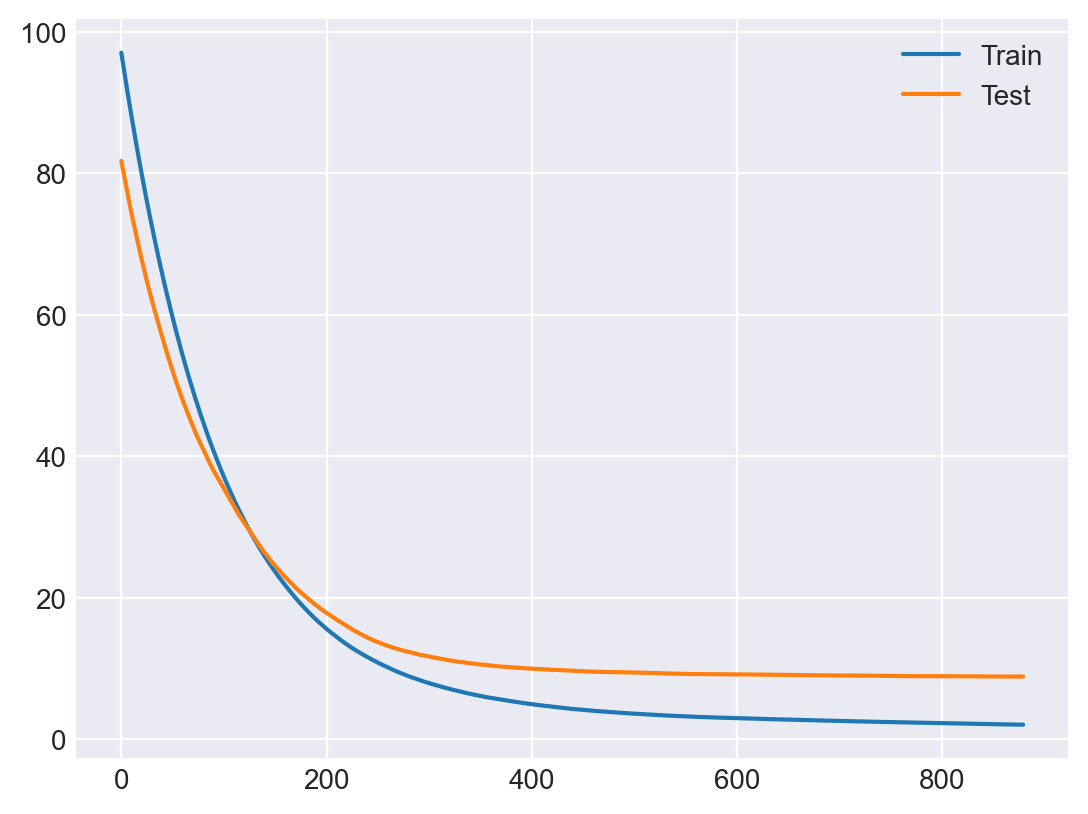

In [19]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

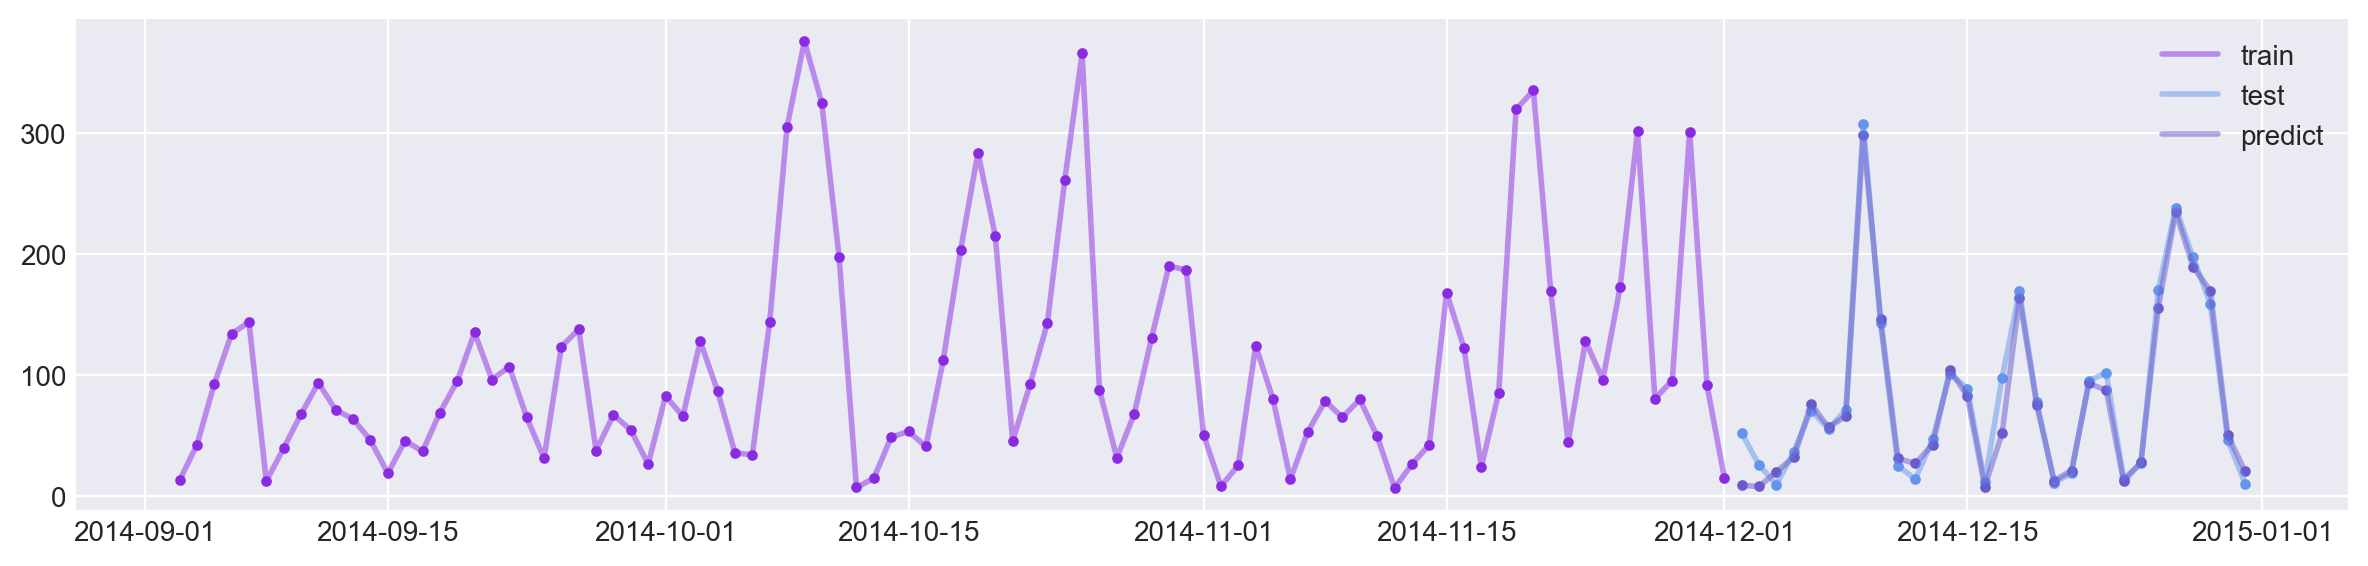

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [21]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=True,
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l1: 52.5095	training's l2: 4939.95	valid_1's l1: 56.8644	valid_1's l2: 4809.58
[2]	training's l1: 48.0534	training's l2: 4156.14	valid_1's l1: 52.0665	valid_1's l2: 4016.17
[3]	training's l1: 44.0802	training's l2: 3512.92	valid_1's l1: 47.0091	valid_1's l2: 3285.29
[4]	training's l1: 40.5173	training's l2: 2983.46	valid_1's l1: 42.9576	valid_1's l2: 2755.07
[5]	training's l1: 37.3013	training's l2: 2537.45	valid_1's l1: 39.1995	valid_1's l2: 2317.06
[6]	training's l1: 34.3313	training's l2: 2166.91	valid_1's l1: 36.0037	valid_1's l2: 1973.45
[7]	training's l1: 31.7117	training's l2: 1861.88	valid_1's l1: 33.255	valid_1's l2: 1692.19
[8]	training's l1: 29.3456	training's l2: 1605.94	valid_1's l1: 30.8153	valid_1's l2: 1458.55
[9]	training's l1: 27.1229	training's l2: 1390.64	valid_1's l1: 28.8399	valid_1's l2: 1270.84
[10]	training's l1: 25.1655	training's l2: 1211.39	valid_1's l1: 26.7746	valid_1's l2: 1110.08
[11]	training's l1: 23.4516	training's l2: 1065.56	valid_1's

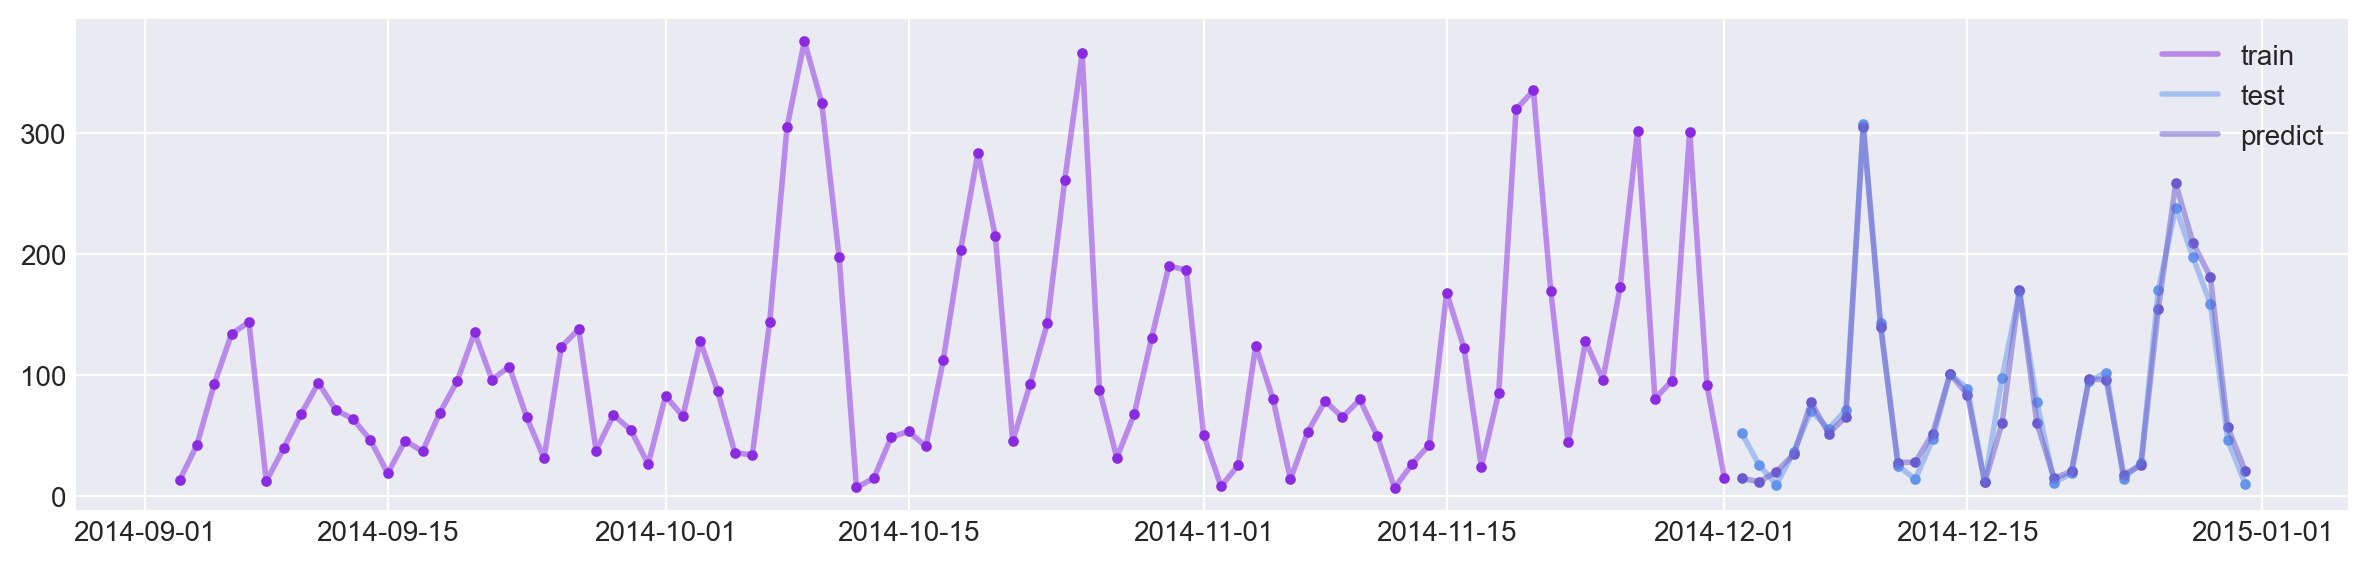

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [23]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=True
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 115.2649653	test: 119.2094318	best: 119.2094318 (0)	total: 148ms	remaining: 2m 27s
1:	learn: 107.0444915	test: 111.3805648	best: 111.3805648 (1)	total: 153ms	remaining: 1m 16s
2:	learn: 100.0313711	test: 104.4947107	best: 104.4947107 (2)	total: 157ms	remaining: 52s
3:	learn: 93.3912362	test: 97.7683861	best: 97.7683861 (3)	total: 161ms	remaining: 40.2s
4:	learn: 87.6934245	test: 92.4194709	best: 92.4194709 (4)	total: 164ms	remaining: 32.6s
5:	learn: 82.7293586	test: 87.0625555	best: 87.0625555 (5)	total: 168ms	remaining: 27.8s
6:	learn: 78.1308161	test: 82.0884286	best: 82.0884286 (6)	total: 181ms	remaining: 25.6s
7:	learn: 73.6581207	test: 77.3196315	best: 77.3196315 (7)	total: 195ms	remaining: 24.2s
8:	learn: 69.9563593	test: 73.2185355	best: 73.2185355 (8)	total: 210ms	remaining: 23.1s
9:	learn: 66.5359992	test: 69.8783462	best: 69.8783462 (9)	total: 224ms	remaining: 22.2s
10:	learn: 63.7246532	test: 67.2615348	best: 67.2615348 (10)	total: 238ms	remaining: 21.4s
11:	learn:

97:	learn: 19.4708572	test: 23.0088915	best: 23.0088915 (97)	total: 1.03s	remaining: 9.5s
98:	learn: 19.2838720	test: 22.8588786	best: 22.8588786 (98)	total: 1.04s	remaining: 9.5s
99:	learn: 19.1779251	test: 22.7809719	best: 22.7809719 (99)	total: 1.06s	remaining: 9.51s
100:	learn: 18.9986240	test: 22.6896503	best: 22.6896503 (100)	total: 1.09s	remaining: 9.7s
101:	learn: 18.7762510	test: 22.5525437	best: 22.5525437 (101)	total: 1.1s	remaining: 9.69s
102:	learn: 18.5767718	test: 22.4203285	best: 22.4203285 (102)	total: 1.11s	remaining: 9.65s
103:	learn: 18.4571501	test: 22.3267304	best: 22.3267304 (103)	total: 1.11s	remaining: 9.61s
104:	learn: 18.2721092	test: 22.1714499	best: 22.1714499 (104)	total: 1.13s	remaining: 9.64s
105:	learn: 18.1970662	test: 22.1355871	best: 22.1355871 (105)	total: 1.15s	remaining: 9.66s
106:	learn: 18.0492719	test: 21.9994390	best: 21.9994390 (106)	total: 1.16s	remaining: 9.67s
107:	learn: 17.8587256	test: 21.8485869	best: 21.8485869 (107)	total: 1.17s	rema

209:	learn: 9.6857711	test: 15.8329601	best: 15.8329601 (209)	total: 1.87s	remaining: 7.03s
210:	learn: 9.6416404	test: 15.8035359	best: 15.8035359 (210)	total: 1.88s	remaining: 7.04s
211:	learn: 9.6130352	test: 15.7910641	best: 15.7910641 (211)	total: 1.9s	remaining: 7.05s
212:	learn: 9.5767840	test: 15.7520282	best: 15.7520282 (212)	total: 1.91s	remaining: 7.06s
213:	learn: 9.5372796	test: 15.7155584	best: 15.7155584 (213)	total: 1.92s	remaining: 7.07s
214:	learn: 9.4824572	test: 15.6649761	best: 15.6649761 (214)	total: 1.94s	remaining: 7.07s
215:	learn: 9.4337081	test: 15.6400582	best: 15.6400582 (215)	total: 1.95s	remaining: 7.07s
216:	learn: 9.3792966	test: 15.6065899	best: 15.6065899 (216)	total: 1.96s	remaining: 7.07s
217:	learn: 9.3394599	test: 15.5868647	best: 15.5868647 (217)	total: 1.97s	remaining: 7.05s
218:	learn: 9.3042246	test: 15.5713943	best: 15.5713943 (218)	total: 1.97s	remaining: 7.04s
219:	learn: 9.2503542	test: 15.5388798	best: 15.5388798 (219)	total: 1.98s	remain

331:	learn: 6.1123082	test: 13.9920913	best: 13.9920913 (331)	total: 2.71s	remaining: 5.45s
332:	learn: 6.0951401	test: 13.9997587	best: 13.9920913 (331)	total: 2.71s	remaining: 5.43s
333:	learn: 6.0820039	test: 13.9876373	best: 13.9876373 (333)	total: 2.71s	remaining: 5.41s
334:	learn: 6.0664717	test: 13.9814298	best: 13.9814298 (334)	total: 2.71s	remaining: 5.38s
335:	learn: 6.0521312	test: 13.9888775	best: 13.9814298 (334)	total: 2.71s	remaining: 5.36s
336:	learn: 6.0353980	test: 13.9679164	best: 13.9679164 (336)	total: 2.71s	remaining: 5.34s
337:	learn: 6.0212548	test: 13.9614370	best: 13.9614370 (337)	total: 2.72s	remaining: 5.33s
338:	learn: 6.0017106	test: 13.9505612	best: 13.9505612 (338)	total: 2.72s	remaining: 5.31s
339:	learn: 5.9779888	test: 13.9386305	best: 13.9386305 (339)	total: 2.73s	remaining: 5.29s
340:	learn: 5.9642257	test: 13.9344133	best: 13.9344133 (340)	total: 2.73s	remaining: 5.28s
341:	learn: 5.9546832	test: 13.9312715	best: 13.9312715 (341)	total: 2.73s	remai

445:	learn: 4.5267679	test: 13.2877103	best: 13.2877103 (445)	total: 3.55s	remaining: 4.41s
446:	learn: 4.5164850	test: 13.2843667	best: 13.2843667 (446)	total: 3.56s	remaining: 4.41s
447:	learn: 4.5090154	test: 13.2846542	best: 13.2843667 (446)	total: 3.58s	remaining: 4.41s
448:	learn: 4.5006034	test: 13.2837301	best: 13.2837301 (448)	total: 3.59s	remaining: 4.41s
449:	learn: 4.4857114	test: 13.2777098	best: 13.2777098 (449)	total: 3.61s	remaining: 4.41s
450:	learn: 4.4792783	test: 13.2782384	best: 13.2777098 (449)	total: 3.62s	remaining: 4.41s
451:	learn: 4.4705492	test: 13.2809728	best: 13.2777098 (449)	total: 3.63s	remaining: 4.4s
452:	learn: 4.4544392	test: 13.2755849	best: 13.2755849 (452)	total: 3.64s	remaining: 4.4s
453:	learn: 4.4435453	test: 13.2651855	best: 13.2651855 (453)	total: 3.65s	remaining: 4.39s
454:	learn: 4.4327796	test: 13.2550097	best: 13.2550097 (454)	total: 3.66s	remaining: 4.38s
455:	learn: 4.4243415	test: 13.2451080	best: 13.2451080 (455)	total: 3.67s	remaini

569:	learn: 3.5706542	test: 12.9871079	best: 12.9871079 (569)	total: 4.37s	remaining: 3.3s
570:	learn: 3.5611202	test: 12.9837954	best: 12.9837954 (570)	total: 4.37s	remaining: 3.29s
571:	learn: 3.5548603	test: 12.9804806	best: 12.9804806 (571)	total: 4.37s	remaining: 3.27s
572:	learn: 3.5472841	test: 12.9815484	best: 12.9804806 (571)	total: 4.37s	remaining: 3.26s
573:	learn: 3.5383371	test: 12.9730821	best: 12.9730821 (573)	total: 4.38s	remaining: 3.25s
574:	learn: 3.5317304	test: 12.9686554	best: 12.9686554 (574)	total: 4.38s	remaining: 3.23s
575:	learn: 3.5283199	test: 12.9672402	best: 12.9672402 (575)	total: 4.38s	remaining: 3.22s
576:	learn: 3.5274031	test: 12.9645305	best: 12.9645305 (576)	total: 4.38s	remaining: 3.21s
577:	learn: 3.5209585	test: 12.9573911	best: 12.9573911 (577)	total: 4.38s	remaining: 3.2s
578:	learn: 3.5160824	test: 12.9570035	best: 12.9570035 (578)	total: 4.38s	remaining: 3.19s
579:	learn: 3.5101334	test: 12.9535274	best: 12.9535274 (579)	total: 4.38s	remaini

678:	learn: 2.9829327	test: 12.8590823	best: 12.8573069 (676)	total: 4.78s	remaining: 2.26s
679:	learn: 2.9788176	test: 12.8575467	best: 12.8573069 (676)	total: 4.8s	remaining: 2.26s
680:	learn: 2.9762479	test: 12.8570747	best: 12.8570747 (680)	total: 4.81s	remaining: 2.25s
681:	learn: 2.9694079	test: 12.8559593	best: 12.8559593 (681)	total: 4.83s	remaining: 2.25s
682:	learn: 2.9654013	test: 12.8525566	best: 12.8525566 (682)	total: 4.84s	remaining: 2.25s
683:	learn: 2.9612307	test: 12.8484259	best: 12.8484259 (683)	total: 4.85s	remaining: 2.24s
684:	learn: 2.9558066	test: 12.8423932	best: 12.8423932 (684)	total: 4.87s	remaining: 2.24s
685:	learn: 2.9503401	test: 12.8393194	best: 12.8393194 (685)	total: 4.88s	remaining: 2.23s
686:	learn: 2.9453822	test: 12.8416042	best: 12.8393194 (685)	total: 4.89s	remaining: 2.23s
687:	learn: 2.9413655	test: 12.8433635	best: 12.8393194 (685)	total: 4.89s	remaining: 2.22s
688:	learn: 2.9371850	test: 12.8401731	best: 12.8393194 (685)	total: 4.9s	remaini

790:	learn: 2.5240933	test: 12.7253771	best: 12.7235241 (780)	total: 6.06s	remaining: 1.6s
791:	learn: 2.5182138	test: 12.7243240	best: 12.7235241 (780)	total: 6.07s	remaining: 1.59s
792:	learn: 2.5179053	test: 12.7240347	best: 12.7235241 (780)	total: 6.09s	remaining: 1.59s
793:	learn: 2.5162288	test: 12.7238830	best: 12.7235241 (780)	total: 6.1s	remaining: 1.58s
794:	learn: 2.5158155	test: 12.7236983	best: 12.7235241 (780)	total: 6.12s	remaining: 1.58s
795:	learn: 2.5141193	test: 12.7252407	best: 12.7235241 (780)	total: 6.13s	remaining: 1.57s
796:	learn: 2.5135342	test: 12.7248334	best: 12.7235241 (780)	total: 6.15s	remaining: 1.57s
797:	learn: 2.5075597	test: 12.7247227	best: 12.7235241 (780)	total: 6.16s	remaining: 1.56s
798:	learn: 2.5011679	test: 12.7209323	best: 12.7209323 (798)	total: 6.18s	remaining: 1.55s
799:	learn: 2.4974983	test: 12.7213643	best: 12.7209323 (798)	total: 6.19s	remaining: 1.55s
800:	learn: 2.4911434	test: 12.7193439	best: 12.7193439 (800)	total: 6.21s	remaini

885:	learn: 2.2403233	test: 12.6765021	best: 12.6744263 (873)	total: 7.15s	remaining: 920ms
886:	learn: 2.2369844	test: 12.6763625	best: 12.6744263 (873)	total: 7.17s	remaining: 913ms
887:	learn: 2.2353625	test: 12.6740418	best: 12.6740418 (887)	total: 7.18s	remaining: 905ms
888:	learn: 2.2319634	test: 12.6748540	best: 12.6740418 (887)	total: 7.19s	remaining: 898ms
889:	learn: 2.2280248	test: 12.6744381	best: 12.6740418 (887)	total: 7.21s	remaining: 891ms
890:	learn: 2.2253173	test: 12.6722252	best: 12.6722252 (890)	total: 7.22s	remaining: 883ms
891:	learn: 2.2248236	test: 12.6718955	best: 12.6718955 (891)	total: 7.23s	remaining: 876ms
892:	learn: 2.2223929	test: 12.6725524	best: 12.6718955 (891)	total: 7.25s	remaining: 868ms
893:	learn: 2.2221911	test: 12.6725095	best: 12.6718955 (891)	total: 7.26s	remaining: 861ms
894:	learn: 2.2182902	test: 12.6723729	best: 12.6718955 (891)	total: 7.27s	remaining: 853ms
895:	learn: 2.2153268	test: 12.6718401	best: 12.6718401 (895)	total: 7.28s	remai

998:	learn: 1.9671415	test: 12.6276137	best: 12.6215246 (987)	total: 8.44s	remaining: 8.45ms
999:	learn: 1.9663193	test: 12.6273808	best: 12.6215246 (987)	total: 8.46s	remaining: 0us

bestTest = 12.62152457
bestIteration = 987

0:	loss: 12.6215246	best: 12.6215246 (0)	total: 8.56s	remaining: 8.56s
0:	learn: 115.4778979	test: 119.4239019	best: 119.4239019 (0)	total: 3.4ms	remaining: 3.4s
1:	learn: 107.3956529	test: 111.7269590	best: 111.7269590 (1)	total: 6.12ms	remaining: 3.05s
2:	learn: 100.4993742	test: 104.9115131	best: 104.9115131 (2)	total: 8.82ms	remaining: 2.93s
3:	learn: 94.0175307	test: 98.3867458	best: 98.3867458 (3)	total: 11.5ms	remaining: 2.87s
4:	learn: 88.3218948	test: 93.0623885	best: 93.0623885 (4)	total: 13.2ms	remaining: 2.63s
5:	learn: 83.4752873	test: 87.9587889	best: 87.9587889 (5)	total: 16.6ms	remaining: 2.75s
6:	learn: 78.9699620	test: 83.1774896	best: 83.1774896 (6)	total: 19.5ms	remaining: 2.76s
7:	learn: 74.6385400	test: 78.5849628	best: 78.5849628 (7)	total

107:	learn: 18.9184522	test: 22.5709979	best: 22.5709979 (107)	total: 1.31s	remaining: 10.9s
108:	learn: 18.7170806	test: 22.3990605	best: 22.3990605 (108)	total: 1.33s	remaining: 10.9s
109:	learn: 18.5875457	test: 22.2136285	best: 22.2136285 (109)	total: 1.34s	remaining: 10.9s
110:	learn: 18.4175652	test: 22.0189986	best: 22.0189986 (110)	total: 1.35s	remaining: 10.9s
111:	learn: 18.3081216	test: 21.9380223	best: 21.9380223 (111)	total: 1.36s	remaining: 10.8s
112:	learn: 18.1857633	test: 21.8516184	best: 21.8516184 (112)	total: 1.37s	remaining: 10.8s
113:	learn: 18.0234559	test: 21.6952345	best: 21.6952345 (113)	total: 1.38s	remaining: 10.8s
114:	learn: 17.8931522	test: 21.5824006	best: 21.5824006 (114)	total: 1.4s	remaining: 10.8s
115:	learn: 17.7892128	test: 21.5375134	best: 21.5375134 (115)	total: 1.41s	remaining: 10.8s
116:	learn: 17.6370054	test: 21.3837532	best: 21.3837532 (116)	total: 1.43s	remaining: 10.8s
117:	learn: 17.5149635	test: 21.2998962	best: 21.2998962 (117)	total: 1

227:	learn: 9.5429664	test: 15.8120682	best: 15.8120682 (227)	total: 2.39s	remaining: 8.09s
228:	learn: 9.5025888	test: 15.7860833	best: 15.7860833 (228)	total: 2.39s	remaining: 8.05s
229:	learn: 9.4582416	test: 15.7774211	best: 15.7774211 (229)	total: 2.39s	remaining: 8.01s
230:	learn: 9.4303950	test: 15.7830046	best: 15.7774211 (229)	total: 2.39s	remaining: 7.96s
231:	learn: 9.3782839	test: 15.7361122	best: 15.7361122 (231)	total: 2.39s	remaining: 7.92s
232:	learn: 9.3581183	test: 15.7668866	best: 15.7361122 (231)	total: 2.39s	remaining: 7.88s
233:	learn: 9.3380985	test: 15.7703519	best: 15.7361122 (231)	total: 2.4s	remaining: 7.84s
234:	learn: 9.3225668	test: 15.7544713	best: 15.7361122 (231)	total: 2.4s	remaining: 7.81s
235:	learn: 9.2787878	test: 15.7382606	best: 15.7361122 (231)	total: 2.4s	remaining: 7.78s
236:	learn: 9.2472135	test: 15.6927029	best: 15.6927029 (236)	total: 2.41s	remaining: 7.75s
237:	learn: 9.2057985	test: 15.6546602	best: 15.6546602 (237)	total: 2.41s	remainin

331:	learn: 6.7586025	test: 14.3421630	best: 14.3421630 (331)	total: 3.02s	remaining: 6.08s
332:	learn: 6.7452691	test: 14.3362646	best: 14.3362646 (332)	total: 3.04s	remaining: 6.08s
333:	learn: 6.7356081	test: 14.3303416	best: 14.3303416 (333)	total: 3.05s	remaining: 6.08s
334:	learn: 6.7233220	test: 14.3206296	best: 14.3206296 (334)	total: 3.06s	remaining: 6.07s
335:	learn: 6.6972398	test: 14.3006637	best: 14.3006637 (335)	total: 3.06s	remaining: 6.06s
336:	learn: 6.6746804	test: 14.2918483	best: 14.2918483 (336)	total: 3.07s	remaining: 6.05s
337:	learn: 6.6615654	test: 14.2851638	best: 14.2851638 (337)	total: 3.08s	remaining: 6.04s
338:	learn: 6.6406053	test: 14.2667597	best: 14.2667597 (338)	total: 3.09s	remaining: 6.03s
339:	learn: 6.6271046	test: 14.2494531	best: 14.2494531 (339)	total: 3.1s	remaining: 6.02s
340:	learn: 6.6032066	test: 14.2335079	best: 14.2335079 (340)	total: 3.11s	remaining: 6.01s
341:	learn: 6.5873229	test: 14.2327844	best: 14.2327844 (341)	total: 3.12s	remain

423:	learn: 5.3716891	test: 13.6769616	best: 13.6769616 (423)	total: 3.86s	remaining: 5.25s
424:	learn: 5.3631150	test: 13.6773385	best: 13.6769616 (423)	total: 3.87s	remaining: 5.23s
425:	learn: 5.3536573	test: 13.6693014	best: 13.6693014 (425)	total: 3.87s	remaining: 5.21s
426:	learn: 5.3342636	test: 13.6668906	best: 13.6668906 (426)	total: 3.87s	remaining: 5.19s
427:	learn: 5.3280420	test: 13.6671858	best: 13.6668906 (426)	total: 3.87s	remaining: 5.17s
428:	learn: 5.3113821	test: 13.6683661	best: 13.6668906 (426)	total: 3.87s	remaining: 5.15s
429:	learn: 5.3038638	test: 13.6555050	best: 13.6555050 (429)	total: 3.87s	remaining: 5.13s
430:	learn: 5.3010244	test: 13.6524945	best: 13.6524945 (430)	total: 3.87s	remaining: 5.11s
431:	learn: 5.2909461	test: 13.6501194	best: 13.6501194 (431)	total: 3.87s	remaining: 5.09s
432:	learn: 5.2821214	test: 13.6532155	best: 13.6501194 (431)	total: 3.87s	remaining: 5.07s
433:	learn: 5.2664107	test: 13.6419369	best: 13.6419369 (433)	total: 3.87s	remai

530:	learn: 4.3136667	test: 13.2797591	best: 13.2797591 (530)	total: 4.27s	remaining: 3.77s
531:	learn: 4.3056636	test: 13.2760897	best: 13.2760897 (531)	total: 4.28s	remaining: 3.77s
532:	learn: 4.3005848	test: 13.2712976	best: 13.2712976 (532)	total: 4.29s	remaining: 3.76s
533:	learn: 4.2885829	test: 13.2667194	best: 13.2667194 (533)	total: 4.3s	remaining: 3.75s
534:	learn: 4.2810513	test: 13.2627720	best: 13.2627720 (534)	total: 4.31s	remaining: 3.74s
535:	learn: 4.2696984	test: 13.2628614	best: 13.2627720 (534)	total: 4.31s	remaining: 3.73s
536:	learn: 4.2614322	test: 13.2545489	best: 13.2545489 (536)	total: 4.32s	remaining: 3.73s
537:	learn: 4.2513355	test: 13.2525577	best: 13.2525577 (537)	total: 4.33s	remaining: 3.71s
538:	learn: 4.2416487	test: 13.2573286	best: 13.2525577 (537)	total: 4.33s	remaining: 3.7s
539:	learn: 4.2334157	test: 13.2550955	best: 13.2525577 (537)	total: 4.34s	remaining: 3.69s
540:	learn: 4.2227830	test: 13.2542086	best: 13.2525577 (537)	total: 4.34s	remaini

623:	learn: 3.6794966	test: 13.0204892	best: 13.0204892 (623)	total: 5.59s	remaining: 3.37s
624:	learn: 3.6747747	test: 13.0234778	best: 13.0204892 (623)	total: 5.6s	remaining: 3.36s
625:	learn: 3.6738148	test: 13.0231670	best: 13.0204892 (623)	total: 5.61s	remaining: 3.35s
626:	learn: 3.6701459	test: 13.0200667	best: 13.0200667 (626)	total: 5.62s	remaining: 3.34s
627:	learn: 3.6648212	test: 13.0200572	best: 13.0200572 (627)	total: 5.68s	remaining: 3.36s
628:	learn: 3.6568914	test: 13.0175276	best: 13.0175276 (628)	total: 5.69s	remaining: 3.36s
629:	learn: 3.6499493	test: 13.0161268	best: 13.0161268 (629)	total: 5.7s	remaining: 3.35s
630:	learn: 3.6420152	test: 13.0117417	best: 13.0117417 (630)	total: 5.71s	remaining: 3.34s
631:	learn: 3.6354810	test: 13.0067865	best: 13.0067865 (631)	total: 5.72s	remaining: 3.33s
632:	learn: 3.6306444	test: 13.0073778	best: 13.0067865 (631)	total: 5.73s	remaining: 3.32s
633:	learn: 3.6224485	test: 13.0124299	best: 13.0067865 (631)	total: 5.74s	remaini

719:	learn: 3.1578220	test: 12.9059360	best: 12.9056373 (718)	total: 6.86s	remaining: 2.67s
720:	learn: 3.1527532	test: 12.9053772	best: 12.9053772 (720)	total: 6.87s	remaining: 2.66s
721:	learn: 3.1497406	test: 12.9058183	best: 12.9053772 (720)	total: 6.88s	remaining: 2.65s
722:	learn: 3.1441016	test: 12.9077888	best: 12.9053772 (720)	total: 6.9s	remaining: 2.64s
723:	learn: 3.1401032	test: 12.9056835	best: 12.9053772 (720)	total: 6.91s	remaining: 2.63s
724:	learn: 3.1339562	test: 12.9050537	best: 12.9050537 (724)	total: 6.92s	remaining: 2.62s
725:	learn: 3.1298968	test: 12.9016565	best: 12.9016565 (725)	total: 6.92s	remaining: 2.61s
726:	learn: 3.1247847	test: 12.8979639	best: 12.8979639 (726)	total: 6.93s	remaining: 2.6s
727:	learn: 3.1225073	test: 12.8958090	best: 12.8958090 (727)	total: 6.98s	remaining: 2.61s
728:	learn: 3.1197632	test: 12.8981437	best: 12.8958090 (727)	total: 6.99s	remaining: 2.6s
729:	learn: 3.1164887	test: 12.8983121	best: 12.8958090 (727)	total: 7.01s	remainin

811:	learn: 2.8098727	test: 12.8392981	best: 12.8362718 (809)	total: 7.93s	remaining: 1.83s
812:	learn: 2.8077597	test: 12.8389466	best: 12.8362718 (809)	total: 7.94s	remaining: 1.83s
813:	learn: 2.8073723	test: 12.8392371	best: 12.8362718 (809)	total: 7.96s	remaining: 1.82s
814:	learn: 2.8048056	test: 12.8431764	best: 12.8362718 (809)	total: 7.97s	remaining: 1.81s
815:	learn: 2.8022679	test: 12.8462088	best: 12.8362718 (809)	total: 7.99s	remaining: 1.8s
816:	learn: 2.8016800	test: 12.8470510	best: 12.8362718 (809)	total: 8s	remaining: 1.79s
817:	learn: 2.7988661	test: 12.8472393	best: 12.8362718 (809)	total: 8.02s	remaining: 1.78s
818:	learn: 2.7960823	test: 12.8461621	best: 12.8362718 (809)	total: 8.03s	remaining: 1.77s
819:	learn: 2.7937084	test: 12.8447181	best: 12.8362718 (809)	total: 8.04s	remaining: 1.76s
820:	learn: 2.7915654	test: 12.8447818	best: 12.8362718 (809)	total: 8.05s	remaining: 1.75s
821:	learn: 2.7870647	test: 12.8438200	best: 12.8362718 (809)	total: 8.06s	remaining

901:	learn: 2.5335440	test: 12.7657936	best: 12.7637844 (892)	total: 9s	remaining: 978ms
902:	learn: 2.5325056	test: 12.7654426	best: 12.7637844 (892)	total: 9s	remaining: 967ms
903:	learn: 2.5274075	test: 12.7640156	best: 12.7637844 (892)	total: 9s	remaining: 956ms
904:	learn: 2.5268027	test: 12.7636508	best: 12.7636508 (904)	total: 9s	remaining: 945ms
905:	learn: 2.5232288	test: 12.7631993	best: 12.7631993 (905)	total: 9s	remaining: 934ms
906:	learn: 2.5193898	test: 12.7605143	best: 12.7605143 (906)	total: 9s	remaining: 923ms
907:	learn: 2.5154302	test: 12.7622648	best: 12.7605143 (906)	total: 9.01s	remaining: 912ms
908:	learn: 2.5123299	test: 12.7634936	best: 12.7605143 (906)	total: 9.01s	remaining: 902ms
909:	learn: 2.5099539	test: 12.7625956	best: 12.7605143 (906)	total: 9.01s	remaining: 891ms
910:	learn: 2.5076466	test: 12.7617933	best: 12.7605143 (906)	total: 9.01s	remaining: 880ms
911:	learn: 2.5050187	test: 12.7609301	best: 12.7605143 (906)	total: 9.01s	remaining: 869ms
912:	l

3:	learn: 96.7548924	test: 94.0431334	best: 94.0431334 (3)	total: 70.4ms	remaining: 17.5s
4:	learn: 90.6791729	test: 88.7029629	best: 88.7029629 (4)	total: 83.9ms	remaining: 16.7s
5:	learn: 85.5132308	test: 83.6876219	best: 83.6876219 (5)	total: 91.9ms	remaining: 15.2s
6:	learn: 80.6851520	test: 79.3356124	best: 79.3356124 (6)	total: 100ms	remaining: 14.2s
7:	learn: 76.4368839	test: 75.8075905	best: 75.8075905 (7)	total: 107ms	remaining: 13.2s
8:	learn: 72.9986097	test: 72.2653012	best: 72.2653012 (8)	total: 153ms	remaining: 16.9s
9:	learn: 69.3561770	test: 68.8968898	best: 68.8968898 (9)	total: 167ms	remaining: 16.5s
10:	learn: 66.4175576	test: 65.8263400	best: 65.8263400 (10)	total: 180ms	remaining: 16.2s
11:	learn: 64.1350241	test: 63.6157692	best: 63.6157692 (11)	total: 194ms	remaining: 16s
12:	learn: 61.1509729	test: 60.7339933	best: 60.7339933 (12)	total: 205ms	remaining: 15.5s
13:	learn: 58.8782617	test: 58.9093523	best: 58.9093523 (13)	total: 214ms	remaining: 15.1s
14:	learn: 5

110:	learn: 17.5157070	test: 21.9049425	best: 21.9049425 (110)	total: 1.38s	remaining: 11s
111:	learn: 17.4491923	test: 21.8873997	best: 21.8873997 (111)	total: 1.39s	remaining: 11s
112:	learn: 17.3915284	test: 21.8678891	best: 21.8678891 (112)	total: 1.4s	remaining: 11s
113:	learn: 17.3027846	test: 21.8294318	best: 21.8294318 (113)	total: 1.41s	remaining: 10.9s
114:	learn: 17.1490845	test: 21.7160891	best: 21.7160891 (114)	total: 1.42s	remaining: 10.9s
115:	learn: 17.0490834	test: 21.6634270	best: 21.6634270 (115)	total: 1.43s	remaining: 10.9s
116:	learn: 16.9349970	test: 21.5575350	best: 21.5575350 (116)	total: 1.43s	remaining: 10.8s
117:	learn: 16.8157051	test: 21.4855381	best: 21.4855381 (117)	total: 1.44s	remaining: 10.8s
118:	learn: 16.6983425	test: 21.3790240	best: 21.3790240 (118)	total: 1.45s	remaining: 10.7s
119:	learn: 16.5837472	test: 21.2883503	best: 21.2883503 (119)	total: 1.47s	remaining: 10.8s
120:	learn: 16.5091713	test: 21.2029604	best: 21.2029604 (120)	total: 1.48s	r

209:	learn: 10.0416971	test: 16.3707067	best: 16.3707067 (209)	total: 2.65s	remaining: 9.96s
210:	learn: 9.9947508	test: 16.3196998	best: 16.3196998 (210)	total: 2.66s	remaining: 9.94s
211:	learn: 9.9439389	test: 16.2810269	best: 16.2810269 (211)	total: 2.66s	remaining: 9.9s
212:	learn: 9.8850333	test: 16.2541208	best: 16.2541208 (212)	total: 2.67s	remaining: 9.87s
213:	learn: 9.8415903	test: 16.1874461	best: 16.1874461 (213)	total: 2.68s	remaining: 9.86s
214:	learn: 9.8106382	test: 16.1636927	best: 16.1636927 (214)	total: 2.7s	remaining: 9.86s
215:	learn: 9.7614228	test: 16.1176604	best: 16.1176604 (215)	total: 2.71s	remaining: 9.85s
216:	learn: 9.7266967	test: 16.0862558	best: 16.0862558 (216)	total: 2.73s	remaining: 9.84s
217:	learn: 9.6717232	test: 16.0507706	best: 16.0507706 (217)	total: 2.74s	remaining: 9.82s
218:	learn: 9.6188513	test: 16.0224956	best: 16.0224956 (218)	total: 2.75s	remaining: 9.8s
219:	learn: 9.5782548	test: 16.0202684	best: 16.0202684 (219)	total: 2.76s	remaini

303:	learn: 7.0370277	test: 14.5118906	best: 14.5118906 (303)	total: 3.96s	remaining: 9.06s
304:	learn: 7.0220518	test: 14.5020056	best: 14.5020056 (304)	total: 3.97s	remaining: 9.04s
305:	learn: 6.9917605	test: 14.4938279	best: 14.4938279 (305)	total: 3.98s	remaining: 9.02s
306:	learn: 6.9573941	test: 14.4696213	best: 14.4696213 (306)	total: 3.99s	remaining: 9s
307:	learn: 6.9266871	test: 14.4508397	best: 14.4508397 (307)	total: 4s	remaining: 8.98s
308:	learn: 6.9080942	test: 14.4426697	best: 14.4426697 (308)	total: 4.03s	remaining: 9.02s
309:	learn: 6.8821062	test: 14.4421034	best: 14.4421034 (309)	total: 4.04s	remaining: 8.99s
310:	learn: 6.8508040	test: 14.4203893	best: 14.4203893 (310)	total: 4.05s	remaining: 8.97s
311:	learn: 6.8401764	test: 14.4178819	best: 14.4178819 (311)	total: 4.06s	remaining: 8.96s
312:	learn: 6.8141099	test: 14.4141327	best: 14.4141327 (312)	total: 4.08s	remaining: 8.95s
313:	learn: 6.7834012	test: 14.3989247	best: 14.3989247 (313)	total: 4.09s	remaining: 

397:	learn: 5.2756451	test: 13.6310346	best: 13.6310346 (397)	total: 5.07s	remaining: 7.67s
398:	learn: 5.2624261	test: 13.6285531	best: 13.6285531 (398)	total: 5.08s	remaining: 7.66s
399:	learn: 5.2442837	test: 13.6201038	best: 13.6201038 (399)	total: 5.1s	remaining: 7.65s
400:	learn: 5.2284195	test: 13.6154499	best: 13.6154499 (400)	total: 5.16s	remaining: 7.7s
401:	learn: 5.2179123	test: 13.6139229	best: 13.6139229 (401)	total: 5.17s	remaining: 7.69s
402:	learn: 5.2044591	test: 13.6133657	best: 13.6133657 (402)	total: 5.19s	remaining: 7.68s
403:	learn: 5.1853585	test: 13.6104832	best: 13.6104832 (403)	total: 5.2s	remaining: 7.67s
404:	learn: 5.1717051	test: 13.6103860	best: 13.6103860 (404)	total: 5.21s	remaining: 7.66s
405:	learn: 5.1621561	test: 13.6017728	best: 13.6017728 (405)	total: 5.23s	remaining: 7.65s
406:	learn: 5.1512339	test: 13.5993057	best: 13.5993057 (406)	total: 5.24s	remaining: 7.64s
407:	learn: 5.1434433	test: 13.5925195	best: 13.5925195 (407)	total: 5.3s	remaining

495:	learn: 4.1717118	test: 13.1651249	best: 13.1651249 (495)	total: 6.56s	remaining: 6.67s
496:	learn: 4.1639315	test: 13.1599491	best: 13.1599491 (496)	total: 6.58s	remaining: 6.66s
497:	learn: 4.1541382	test: 13.1618992	best: 13.1599491 (496)	total: 6.61s	remaining: 6.66s
498:	learn: 4.1454321	test: 13.1530676	best: 13.1530676 (498)	total: 6.62s	remaining: 6.64s
499:	learn: 4.1358527	test: 13.1500622	best: 13.1500622 (499)	total: 6.63s	remaining: 6.63s
500:	learn: 4.1295334	test: 13.1552017	best: 13.1500622 (499)	total: 6.64s	remaining: 6.62s
501:	learn: 4.1209431	test: 13.1523410	best: 13.1500622 (499)	total: 6.66s	remaining: 6.61s
502:	learn: 4.1151216	test: 13.1453605	best: 13.1453605 (502)	total: 6.67s	remaining: 6.59s
503:	learn: 4.1124046	test: 13.1493834	best: 13.1453605 (502)	total: 6.67s	remaining: 6.57s
504:	learn: 4.1075336	test: 13.1498571	best: 13.1453605 (502)	total: 6.68s	remaining: 6.55s
505:	learn: 4.0940350	test: 13.1502920	best: 13.1453605 (502)	total: 6.69s	remai

590:	learn: 3.4553680	test: 12.9200373	best: 12.9200373 (590)	total: 9.03s	remaining: 6.25s
591:	learn: 3.4484203	test: 12.9126512	best: 12.9126512 (591)	total: 9.04s	remaining: 6.23s
592:	learn: 3.4402832	test: 12.9079567	best: 12.9079567 (592)	total: 9.05s	remaining: 6.21s
593:	learn: 3.4362551	test: 12.9091127	best: 12.9079567 (592)	total: 9.07s	remaining: 6.2s
594:	learn: 3.4314505	test: 12.9072288	best: 12.9072288 (594)	total: 9.08s	remaining: 6.18s
595:	learn: 3.4216014	test: 12.8984053	best: 12.8984053 (595)	total: 9.1s	remaining: 6.17s
596:	learn: 3.4151029	test: 12.8906548	best: 12.8906548 (596)	total: 9.43s	remaining: 6.36s
597:	learn: 3.4077171	test: 12.8910828	best: 12.8906548 (596)	total: 9.57s	remaining: 6.43s
598:	learn: 3.4019162	test: 12.8891171	best: 12.8891171 (598)	total: 9.67s	remaining: 6.47s
599:	learn: 3.3947721	test: 12.8808825	best: 12.8808825 (599)	total: 9.68s	remaining: 6.46s
600:	learn: 3.3863388	test: 12.8777103	best: 12.8777103 (600)	total: 9.7s	remainin

696:	learn: 2.8456504	test: 12.7086766	best: 12.7086766 (696)	total: 13.8s	remaining: 6.01s
697:	learn: 2.8390455	test: 12.7085925	best: 12.7085925 (697)	total: 13.8s	remaining: 5.98s
698:	learn: 2.8331404	test: 12.7074108	best: 12.7074108 (698)	total: 13.8s	remaining: 5.95s
699:	learn: 2.8293589	test: 12.7068741	best: 12.7068741 (699)	total: 13.8s	remaining: 5.92s
700:	learn: 2.8261049	test: 12.7092366	best: 12.7068741 (699)	total: 13.8s	remaining: 5.9s
701:	learn: 2.8225183	test: 12.7105149	best: 12.7068741 (699)	total: 13.8s	remaining: 5.87s
702:	learn: 2.8173297	test: 12.7072251	best: 12.7068741 (699)	total: 13.8s	remaining: 5.84s
703:	learn: 2.8102750	test: 12.7100055	best: 12.7068741 (699)	total: 13.8s	remaining: 5.82s
704:	learn: 2.8070657	test: 12.7085184	best: 12.7068741 (699)	total: 13.8s	remaining: 5.79s
705:	learn: 2.8004979	test: 12.7055451	best: 12.7055451 (705)	total: 13.8s	remaining: 5.76s
706:	learn: 2.7951119	test: 12.7036977	best: 12.7036977 (706)	total: 13.8s	remain

793:	learn: 2.4419187	test: 12.6008963	best: 12.6008077 (792)	total: 16.2s	remaining: 4.21s
794:	learn: 2.4380766	test: 12.5983998	best: 12.5983998 (794)	total: 16.4s	remaining: 4.24s
795:	learn: 2.4364980	test: 12.5973208	best: 12.5973208 (795)	total: 16.4s	remaining: 4.21s
796:	learn: 2.4326894	test: 12.5950470	best: 12.5950470 (796)	total: 16.4s	remaining: 4.19s
797:	learn: 2.4260678	test: 12.5954714	best: 12.5950470 (796)	total: 16.4s	remaining: 4.16s
798:	learn: 2.4224957	test: 12.5947796	best: 12.5947796 (798)	total: 16.4s	remaining: 4.14s
799:	learn: 2.4170708	test: 12.5956133	best: 12.5947796 (798)	total: 16.5s	remaining: 4.11s
800:	learn: 2.4150160	test: 12.5945709	best: 12.5945709 (800)	total: 16.5s	remaining: 4.09s
801:	learn: 2.4124977	test: 12.5896964	best: 12.5896964 (801)	total: 16.5s	remaining: 4.06s
802:	learn: 2.4085664	test: 12.5888361	best: 12.5888361 (802)	total: 16.5s	remaining: 4.04s
803:	learn: 2.4051421	test: 12.5888614	best: 12.5888361 (802)	total: 16.5s	remai

884:	learn: 2.1295069	test: 12.5213559	best: 12.5213559 (884)	total: 18.3s	remaining: 2.38s
885:	learn: 2.1267668	test: 12.5214159	best: 12.5213559 (884)	total: 18.3s	remaining: 2.36s
886:	learn: 2.1246227	test: 12.5217462	best: 12.5213559 (884)	total: 18.4s	remaining: 2.34s
887:	learn: 2.1194696	test: 12.5197625	best: 12.5197625 (887)	total: 18.4s	remaining: 2.32s
888:	learn: 2.1162814	test: 12.5178311	best: 12.5178311 (888)	total: 18.4s	remaining: 2.29s
889:	learn: 2.1141081	test: 12.5168579	best: 12.5168579 (889)	total: 18.4s	remaining: 2.27s
890:	learn: 2.1097179	test: 12.5185523	best: 12.5168579 (889)	total: 18.4s	remaining: 2.25s
891:	learn: 2.1068577	test: 12.5192009	best: 12.5168579 (889)	total: 18.4s	remaining: 2.23s
892:	learn: 2.1045506	test: 12.5187340	best: 12.5168579 (889)	total: 18.5s	remaining: 2.21s
893:	learn: 2.1019970	test: 12.5199917	best: 12.5168579 (889)	total: 18.5s	remaining: 2.19s
894:	learn: 2.0984274	test: 12.5192642	best: 12.5168579 (889)	total: 18.5s	remai

983:	learn: 1.8462243	test: 12.4641435	best: 12.4639185 (980)	total: 19.9s	remaining: 323ms
984:	learn: 1.8440560	test: 12.4641653	best: 12.4639185 (980)	total: 19.9s	remaining: 303ms
985:	learn: 1.8399971	test: 12.4632107	best: 12.4632107 (985)	total: 20s	remaining: 284ms
986:	learn: 1.8363536	test: 12.4616954	best: 12.4616954 (986)	total: 20s	remaining: 264ms
987:	learn: 1.8336497	test: 12.4633954	best: 12.4616954 (986)	total: 20.1s	remaining: 244ms
988:	learn: 1.8313393	test: 12.4635907	best: 12.4616954 (986)	total: 20.1s	remaining: 224ms
989:	learn: 1.8288359	test: 12.4621620	best: 12.4616954 (986)	total: 20.2s	remaining: 204ms
990:	learn: 1.8254471	test: 12.4612698	best: 12.4612698 (990)	total: 20.2s	remaining: 184ms
991:	learn: 1.8220149	test: 12.4602838	best: 12.4602838 (991)	total: 20.4s	remaining: 164ms
992:	learn: 1.8188122	test: 12.4593664	best: 12.4593664 (992)	total: 20.4s	remaining: 144ms
993:	learn: 1.8158483	test: 12.4583459	best: 12.4583459 (993)	total: 20.5s	remaining

75:	learn: 22.3539368	test: 32.2962690	best: 32.2962690 (75)	total: 4.96s	remaining: 1m
76:	learn: 22.0844500	test: 32.1084121	best: 32.1084121 (76)	total: 5.19s	remaining: 1m 2s
77:	learn: 21.7957435	test: 31.9432302	best: 31.9432302 (77)	total: 5.2s	remaining: 1m 1s
78:	learn: 21.5997443	test: 31.7355116	best: 31.7355116 (78)	total: 5.22s	remaining: 1m
79:	learn: 21.3896540	test: 31.5988335	best: 31.5988335 (79)	total: 5.23s	remaining: 1m
80:	learn: 21.1726512	test: 31.4307907	best: 31.4307907 (80)	total: 5.25s	remaining: 59.5s
81:	learn: 20.9370305	test: 31.3025696	best: 31.3025696 (81)	total: 5.26s	remaining: 58.9s
82:	learn: 20.7352779	test: 31.0788026	best: 31.0788026 (82)	total: 5.28s	remaining: 58.4s
83:	learn: 20.5890108	test: 30.9391210	best: 30.9391210 (83)	total: 5.3s	remaining: 57.8s
84:	learn: 20.4348583	test: 30.8211388	best: 30.8211388 (84)	total: 5.31s	remaining: 57.2s
85:	learn: 20.3252138	test: 30.7414524	best: 30.7414524 (85)	total: 5.33s	remaining: 56.7s
86:	learn:

172:	learn: 10.6231565	test: 23.3424984	best: 23.3424984 (172)	total: 9.07s	remaining: 43.4s
173:	learn: 10.5801638	test: 23.3153045	best: 23.3153045 (173)	total: 9.22s	remaining: 43.8s
174:	learn: 10.5057571	test: 23.2790314	best: 23.2790314 (174)	total: 9.37s	remaining: 44.2s
175:	learn: 10.4440180	test: 23.2354232	best: 23.2354232 (175)	total: 9.57s	remaining: 44.8s
176:	learn: 10.4020081	test: 23.2091549	best: 23.2091549 (176)	total: 9.65s	remaining: 44.9s
177:	learn: 10.3576475	test: 23.1814174	best: 23.1814174 (177)	total: 9.66s	remaining: 44.6s
178:	learn: 10.3066393	test: 23.1231528	best: 23.1231528 (178)	total: 9.67s	remaining: 44.4s
179:	learn: 10.2502442	test: 23.0928229	best: 23.0928229 (179)	total: 9.7s	remaining: 44.2s
180:	learn: 10.1908859	test: 22.9983607	best: 22.9983607 (180)	total: 9.97s	remaining: 45.1s
181:	learn: 10.1488688	test: 22.9379601	best: 22.9379601 (181)	total: 9.97s	remaining: 44.8s
182:	learn: 10.0960882	test: 22.9182185	best: 22.9182185 (182)	total: 9

264:	learn: 7.1842361	test: 20.8731990	best: 20.8731990 (264)	total: 11.3s	remaining: 31.3s
265:	learn: 7.1621610	test: 20.8659767	best: 20.8659767 (265)	total: 11.3s	remaining: 31.2s
266:	learn: 7.1416774	test: 20.8631964	best: 20.8631964 (266)	total: 11.3s	remaining: 31s
267:	learn: 7.1168206	test: 20.8484848	best: 20.8484848 (267)	total: 11.3s	remaining: 30.9s
268:	learn: 7.0928100	test: 20.8310294	best: 20.8310294 (268)	total: 11.3s	remaining: 30.7s
269:	learn: 7.0742701	test: 20.8211424	best: 20.8211424 (269)	total: 11.3s	remaining: 30.6s
270:	learn: 7.0436691	test: 20.8142744	best: 20.8142744 (270)	total: 11.4s	remaining: 30.8s
271:	learn: 7.0202173	test: 20.7695312	best: 20.7695312 (271)	total: 11.4s	remaining: 30.6s
272:	learn: 6.9997035	test: 20.7525678	best: 20.7525678 (272)	total: 11.4s	remaining: 30.5s
273:	learn: 6.9713040	test: 20.7364188	best: 20.7364188 (273)	total: 11.4s	remaining: 30.3s
274:	learn: 6.9522933	test: 20.7267453	best: 20.7267453 (274)	total: 11.4s	remaini

362:	learn: 5.3405510	test: 19.9644351	best: 19.9644351 (362)	total: 12.8s	remaining: 22.5s
363:	learn: 5.3241332	test: 19.9781033	best: 19.9644351 (362)	total: 13s	remaining: 22.6s
364:	learn: 5.3119964	test: 19.9562588	best: 19.9562588 (364)	total: 13s	remaining: 22.6s
365:	learn: 5.2932735	test: 19.9449144	best: 19.9449144 (365)	total: 13.1s	remaining: 22.7s
366:	learn: 5.2793068	test: 19.9396583	best: 19.9396583 (366)	total: 13.4s	remaining: 23s
367:	learn: 5.2681222	test: 19.9390961	best: 19.9390961 (367)	total: 13.5s	remaining: 23.1s
368:	learn: 5.2574001	test: 19.9374368	best: 19.9374368 (368)	total: 13.5s	remaining: 23.1s
369:	learn: 5.2490148	test: 19.9365958	best: 19.9365958 (369)	total: 13.6s	remaining: 23.2s
370:	learn: 5.2359930	test: 19.9357115	best: 19.9357115 (370)	total: 13.6s	remaining: 23.1s
371:	learn: 5.2217804	test: 19.9268369	best: 19.9268369 (371)	total: 13.7s	remaining: 23.1s
372:	learn: 5.2070582	test: 19.9158497	best: 19.9158497 (372)	total: 13.7s	remaining: 

453:	learn: 4.3192452	test: 19.5841878	best: 19.5840623 (450)	total: 15.6s	remaining: 18.8s
454:	learn: 4.3083629	test: 19.5811477	best: 19.5811477 (454)	total: 15.8s	remaining: 18.9s
455:	learn: 4.2938217	test: 19.5776360	best: 19.5776360 (455)	total: 15.8s	remaining: 18.9s
456:	learn: 4.2834343	test: 19.5699966	best: 19.5699966 (456)	total: 15.8s	remaining: 18.8s
457:	learn: 4.2677649	test: 19.5697622	best: 19.5697622 (457)	total: 15.8s	remaining: 18.7s
458:	learn: 4.2595451	test: 19.5538162	best: 19.5538162 (458)	total: 15.8s	remaining: 18.6s
459:	learn: 4.2492260	test: 19.5525482	best: 19.5525482 (459)	total: 15.8s	remaining: 18.6s
460:	learn: 4.2371011	test: 19.5532221	best: 19.5525482 (459)	total: 15.8s	remaining: 18.5s
461:	learn: 4.2283672	test: 19.5503654	best: 19.5503654 (461)	total: 15.8s	remaining: 18.4s
462:	learn: 4.2198605	test: 19.5449501	best: 19.5449501 (462)	total: 15.8s	remaining: 18.4s
463:	learn: 4.2135505	test: 19.5413350	best: 19.5413350 (463)	total: 15.8s	remai

552:	learn: 3.4981224	test: 19.3567224	best: 19.3567224 (552)	total: 18.1s	remaining: 14.7s
553:	learn: 3.4883516	test: 19.3532889	best: 19.3532889 (553)	total: 18.1s	remaining: 14.6s
554:	learn: 3.4827845	test: 19.3559471	best: 19.3532889 (553)	total: 18.1s	remaining: 14.5s
555:	learn: 3.4743759	test: 19.3558547	best: 19.3532889 (553)	total: 18.1s	remaining: 14.5s
556:	learn: 3.4665238	test: 19.3538035	best: 19.3532889 (553)	total: 18.1s	remaining: 14.4s
557:	learn: 3.4561792	test: 19.3502989	best: 19.3502989 (557)	total: 18.1s	remaining: 14.4s
558:	learn: 3.4489280	test: 19.3499838	best: 19.3499838 (558)	total: 18.1s	remaining: 14.3s
559:	learn: 3.4432489	test: 19.3487970	best: 19.3487970 (559)	total: 18.1s	remaining: 14.3s
560:	learn: 3.4382366	test: 19.3458112	best: 19.3458112 (560)	total: 18.1s	remaining: 14.2s
561:	learn: 3.4336969	test: 19.3419160	best: 19.3419160 (561)	total: 18.1s	remaining: 14.1s
562:	learn: 3.4273893	test: 19.3420225	best: 19.3419160 (561)	total: 18.1s	remai

649:	learn: 2.9202907	test: 19.2111435	best: 19.2081496 (648)	total: 21.5s	remaining: 11.6s
650:	learn: 2.9137025	test: 19.2079279	best: 19.2079279 (650)	total: 21.5s	remaining: 11.5s
651:	learn: 2.9095925	test: 19.2072143	best: 19.2072143 (651)	total: 21.5s	remaining: 11.5s
652:	learn: 2.9039529	test: 19.2065990	best: 19.2065990 (652)	total: 21.5s	remaining: 11.4s
653:	learn: 2.8986425	test: 19.2090172	best: 19.2065990 (652)	total: 21.5s	remaining: 11.4s
654:	learn: 2.8934683	test: 19.2068363	best: 19.2065990 (652)	total: 21.5s	remaining: 11.3s
655:	learn: 2.8880627	test: 19.2057987	best: 19.2057987 (655)	total: 21.5s	remaining: 11.3s
656:	learn: 2.8834648	test: 19.2057062	best: 19.2057062 (656)	total: 21.5s	remaining: 11.2s
657:	learn: 2.8823673	test: 19.2054672	best: 19.2054672 (657)	total: 21.5s	remaining: 11.2s
658:	learn: 2.8790746	test: 19.1983854	best: 19.1983854 (658)	total: 21.5s	remaining: 11.1s
659:	learn: 2.8759344	test: 19.1992645	best: 19.1983854 (658)	total: 21.5s	remai

741:	learn: 2.5459809	test: 19.1261822	best: 19.1257757 (739)	total: 22.2s	remaining: 7.72s
742:	learn: 2.5410931	test: 19.1250536	best: 19.1250536 (742)	total: 22.2s	remaining: 7.68s
743:	learn: 2.5366814	test: 19.1241061	best: 19.1241061 (743)	total: 22.2s	remaining: 7.64s
744:	learn: 2.5318722	test: 19.1244246	best: 19.1241061 (743)	total: 22.2s	remaining: 7.6s
745:	learn: 2.5271074	test: 19.1172578	best: 19.1172578 (745)	total: 22.2s	remaining: 7.56s
746:	learn: 2.5229894	test: 19.1161936	best: 19.1161936 (746)	total: 22.2s	remaining: 7.52s
747:	learn: 2.5219973	test: 19.1109189	best: 19.1109189 (747)	total: 22.2s	remaining: 7.49s
748:	learn: 2.5185778	test: 19.1134909	best: 19.1109189 (747)	total: 22.2s	remaining: 7.45s
749:	learn: 2.5138217	test: 19.1120642	best: 19.1109189 (747)	total: 22.2s	remaining: 7.41s
750:	learn: 2.5082014	test: 19.1095198	best: 19.1095198 (750)	total: 22.2s	remaining: 7.37s
751:	learn: 2.5016869	test: 19.1080554	best: 19.1080554 (751)	total: 22.2s	remain

833:	learn: 2.2108852	test: 19.0376670	best: 19.0373315 (832)	total: 24.3s	remaining: 4.83s
834:	learn: 2.2088567	test: 19.0389295	best: 19.0373315 (832)	total: 24.3s	remaining: 4.79s
835:	learn: 2.2076241	test: 19.0392409	best: 19.0373315 (832)	total: 24.3s	remaining: 4.76s
836:	learn: 2.2058469	test: 19.0342667	best: 19.0342667 (836)	total: 24.3s	remaining: 4.73s
837:	learn: 2.2030399	test: 19.0334757	best: 19.0334757 (837)	total: 24.4s	remaining: 4.71s
838:	learn: 2.1975973	test: 19.0346540	best: 19.0334757 (837)	total: 24.4s	remaining: 4.68s
839:	learn: 2.1942387	test: 19.0362029	best: 19.0334757 (837)	total: 24.4s	remaining: 4.65s
840:	learn: 2.1903269	test: 19.0370362	best: 19.0334757 (837)	total: 24.5s	remaining: 4.63s
841:	learn: 2.1873821	test: 19.0369240	best: 19.0334757 (837)	total: 24.5s	remaining: 4.6s
842:	learn: 2.1825407	test: 19.0368129	best: 19.0334757 (837)	total: 24.5s	remaining: 4.57s
843:	learn: 2.1783247	test: 19.0407092	best: 19.0334757 (837)	total: 24.5s	remain

923:	learn: 1.9379379	test: 18.9950421	best: 18.9941373 (922)	total: 27.2s	remaining: 2.24s
924:	learn: 1.9322716	test: 18.9953989	best: 18.9941373 (922)	total: 27.2s	remaining: 2.21s
925:	learn: 1.9292365	test: 18.9911152	best: 18.9911152 (925)	total: 27.2s	remaining: 2.18s
926:	learn: 1.9274454	test: 18.9909300	best: 18.9909300 (926)	total: 27.3s	remaining: 2.15s
927:	learn: 1.9235804	test: 18.9907604	best: 18.9907604 (927)	total: 27.5s	remaining: 2.13s
928:	learn: 1.9223957	test: 18.9899705	best: 18.9899705 (928)	total: 27.5s	remaining: 2.1s
929:	learn: 1.9175290	test: 18.9860890	best: 18.9860890 (929)	total: 27.5s	remaining: 2.07s
930:	learn: 1.9142444	test: 18.9846297	best: 18.9846297 (930)	total: 27.5s	remaining: 2.04s
931:	learn: 1.9121151	test: 18.9865890	best: 18.9846297 (930)	total: 27.5s	remaining: 2.01s
932:	learn: 1.9097187	test: 18.9856112	best: 18.9846297 (930)	total: 27.5s	remaining: 1.98s
933:	learn: 1.9067653	test: 18.9861425	best: 18.9846297 (930)	total: 27.5s	remain

55:	learn: 27.7215445	test: 29.8078555	best: 29.8078555 (55)	total: 209ms	remaining: 3.53s
56:	learn: 27.4444866	test: 29.5476573	best: 29.5476573 (56)	total: 227ms	remaining: 3.75s
57:	learn: 27.1131478	test: 29.2781436	best: 29.2781436 (57)	total: 238ms	remaining: 3.87s
58:	learn: 26.9508805	test: 29.1762920	best: 29.1762920 (58)	total: 251ms	remaining: 4s
59:	learn: 26.5477879	test: 28.7373849	best: 28.7373849 (59)	total: 267ms	remaining: 4.18s
60:	learn: 26.4108462	test: 28.6509554	best: 28.6509554 (60)	total: 294ms	remaining: 4.52s
61:	learn: 26.1553030	test: 28.3922912	best: 28.3922912 (61)	total: 311ms	remaining: 4.7s
62:	learn: 25.8048238	test: 28.1609885	best: 28.1609885 (62)	total: 344ms	remaining: 5.11s
63:	learn: 25.6262334	test: 27.9575788	best: 27.9575788 (63)	total: 450ms	remaining: 6.58s
64:	learn: 25.3287744	test: 27.7132928	best: 27.7132928 (64)	total: 462ms	remaining: 6.65s
65:	learn: 25.0278303	test: 27.4431272	best: 27.4431272 (65)	total: 479ms	remaining: 6.77s
66:

145:	learn: 13.7573848	test: 18.9042929	best: 18.9042929 (145)	total: 4.63s	remaining: 27.1s
146:	learn: 13.6934319	test: 18.9068759	best: 18.9042929 (145)	total: 4.65s	remaining: 27s
147:	learn: 13.5752242	test: 18.8207036	best: 18.8207036 (147)	total: 4.76s	remaining: 27.4s
148:	learn: 13.4894621	test: 18.7549134	best: 18.7549134 (148)	total: 4.91s	remaining: 28s
149:	learn: 13.3892069	test: 18.6657764	best: 18.6657764 (149)	total: 5.03s	remaining: 28.5s
150:	learn: 13.2910263	test: 18.5591539	best: 18.5591539 (150)	total: 5.18s	remaining: 29.2s
151:	learn: 13.2362797	test: 18.5448916	best: 18.5448916 (151)	total: 5.2s	remaining: 29s
152:	learn: 13.1431175	test: 18.4785377	best: 18.4785377 (152)	total: 5.21s	remaining: 28.9s
153:	learn: 13.0506444	test: 18.4085406	best: 18.4085406 (153)	total: 5.32s	remaining: 29.2s
154:	learn: 12.9968438	test: 18.3593977	best: 18.3593977 (154)	total: 5.44s	remaining: 29.6s
155:	learn: 12.9305593	test: 18.3156788	best: 18.3156788 (155)	total: 5.46s	r

239:	learn: 8.5907447	test: 15.4426262	best: 15.4426262 (239)	total: 7.75s	remaining: 24.6s
240:	learn: 8.5506395	test: 15.4036260	best: 15.4036260 (240)	total: 7.77s	remaining: 24.5s
241:	learn: 8.5305730	test: 15.3898322	best: 15.3898322 (241)	total: 7.89s	remaining: 24.7s
242:	learn: 8.4856409	test: 15.3633433	best: 15.3633433 (242)	total: 8s	remaining: 24.9s
243:	learn: 8.4593526	test: 15.3888772	best: 15.3633433 (242)	total: 8.12s	remaining: 25.2s
244:	learn: 8.4144422	test: 15.3423388	best: 15.3423388 (244)	total: 8.13s	remaining: 25.1s
245:	learn: 8.3845759	test: 15.3343755	best: 15.3343755 (245)	total: 8.19s	remaining: 25.1s
246:	learn: 8.3623642	test: 15.3247043	best: 15.3247043 (246)	total: 8.21s	remaining: 25s
247:	learn: 8.3364077	test: 15.3080156	best: 15.3080156 (247)	total: 8.22s	remaining: 24.9s
248:	learn: 8.2886687	test: 15.2792817	best: 15.2792817 (248)	total: 8.23s	remaining: 24.8s
249:	learn: 8.2480546	test: 15.2503967	best: 15.2503967 (249)	total: 8.25s	remaining:

342:	learn: 5.9773882	test: 14.1809875	best: 14.1794191 (341)	total: 11.2s	remaining: 21.4s
343:	learn: 5.9657856	test: 14.1661200	best: 14.1661200 (343)	total: 11.2s	remaining: 21.3s
344:	learn: 5.9405866	test: 14.1462031	best: 14.1462031 (344)	total: 11.2s	remaining: 21.3s
345:	learn: 5.9256848	test: 14.1429891	best: 14.1429891 (345)	total: 11.2s	remaining: 21.2s
346:	learn: 5.9048599	test: 14.1313038	best: 14.1313038 (346)	total: 11.2s	remaining: 21.1s
347:	learn: 5.8871901	test: 14.1185923	best: 14.1185923 (347)	total: 11.2s	remaining: 21.1s
348:	learn: 5.8786036	test: 14.1181149	best: 14.1181149 (348)	total: 11.3s	remaining: 21s
349:	learn: 5.8587232	test: 14.1010249	best: 14.1010249 (349)	total: 11.3s	remaining: 21s
350:	learn: 5.8457542	test: 14.1079441	best: 14.1010249 (349)	total: 11.3s	remaining: 20.9s
351:	learn: 5.8223207	test: 14.0958248	best: 14.0958248 (351)	total: 11.3s	remaining: 20.8s
352:	learn: 5.8008365	test: 14.0826641	best: 14.0826641 (352)	total: 11.4s	remaining

436:	learn: 4.7311616	test: 13.6779900	best: 13.6779900 (436)	total: 14.1s	remaining: 18.1s
437:	learn: 4.7175759	test: 13.6632852	best: 13.6632852 (437)	total: 14.1s	remaining: 18.1s
438:	learn: 4.7028156	test: 13.6489781	best: 13.6489781 (438)	total: 14.2s	remaining: 18.1s
439:	learn: 4.7003879	test: 13.6486605	best: 13.6486605 (439)	total: 14.3s	remaining: 18.2s
440:	learn: 4.6886728	test: 13.6409540	best: 13.6409540 (440)	total: 14.3s	remaining: 18.1s
441:	learn: 4.6718611	test: 13.6283350	best: 13.6283350 (441)	total: 14.3s	remaining: 18.1s
442:	learn: 4.6587832	test: 13.6251419	best: 13.6251419 (442)	total: 14.3s	remaining: 18s
443:	learn: 4.6506572	test: 13.6223889	best: 13.6223889 (443)	total: 14.3s	remaining: 18s
444:	learn: 4.6412020	test: 13.6249808	best: 13.6223889 (443)	total: 14.4s	remaining: 17.9s
445:	learn: 4.6363274	test: 13.6248379	best: 13.6223889 (443)	total: 14.4s	remaining: 17.9s
446:	learn: 4.6267131	test: 13.6229526	best: 13.6223889 (443)	total: 14.4s	remaining

532:	learn: 3.8358513	test: 13.2815964	best: 13.2815964 (532)	total: 15.2s	remaining: 13.3s
533:	learn: 3.8281844	test: 13.2830529	best: 13.2815964 (532)	total: 15.2s	remaining: 13.3s
534:	learn: 3.8178177	test: 13.2820932	best: 13.2815964 (532)	total: 15.2s	remaining: 13.2s
535:	learn: 3.8106422	test: 13.2814348	best: 13.2814348 (535)	total: 15.3s	remaining: 13.2s
536:	learn: 3.8027261	test: 13.2773582	best: 13.2773582 (536)	total: 15.3s	remaining: 13.2s
537:	learn: 3.7929660	test: 13.2675970	best: 13.2675970 (537)	total: 15.3s	remaining: 13.1s
538:	learn: 3.7851789	test: 13.2614682	best: 13.2614682 (538)	total: 15.3s	remaining: 13.1s
539:	learn: 3.7733888	test: 13.2644556	best: 13.2614682 (538)	total: 15.3s	remaining: 13s
540:	learn: 3.7664290	test: 13.2634240	best: 13.2614682 (538)	total: 15.3s	remaining: 13s
541:	learn: 3.7601248	test: 13.2657062	best: 13.2614682 (538)	total: 15.3s	remaining: 13s
542:	learn: 3.7520402	test: 13.2644994	best: 13.2614682 (538)	total: 15.4s	remaining: 

636:	learn: 3.1259393	test: 13.0748894	best: 13.0748894 (636)	total: 19.1s	remaining: 10.9s
637:	learn: 3.1207142	test: 13.0715250	best: 13.0715250 (637)	total: 19.1s	remaining: 10.8s
638:	learn: 3.1134045	test: 13.0664466	best: 13.0664466 (638)	total: 19.1s	remaining: 10.8s
639:	learn: 3.1076458	test: 13.0700731	best: 13.0664466 (638)	total: 19.1s	remaining: 10.7s
640:	learn: 3.1030028	test: 13.0681106	best: 13.0664466 (638)	total: 19.1s	remaining: 10.7s
641:	learn: 3.0981293	test: 13.0682397	best: 13.0664466 (638)	total: 19.1s	remaining: 10.7s
642:	learn: 3.0901479	test: 13.0626795	best: 13.0626795 (642)	total: 19.1s	remaining: 10.6s
643:	learn: 3.0847156	test: 13.0602816	best: 13.0602816 (643)	total: 19.1s	remaining: 10.6s
644:	learn: 3.0803177	test: 13.0610068	best: 13.0602816 (643)	total: 19.2s	remaining: 10.5s
645:	learn: 3.0744743	test: 13.0605081	best: 13.0602816 (643)	total: 19.2s	remaining: 10.5s
646:	learn: 3.0716907	test: 13.0613770	best: 13.0602816 (643)	total: 19.2s	remai

734:	learn: 2.6909612	test: 12.9374434	best: 12.9374434 (734)	total: 24.1s	remaining: 8.68s
735:	learn: 2.6875264	test: 12.9379494	best: 12.9374434 (734)	total: 24.1s	remaining: 8.64s
736:	learn: 2.6840196	test: 12.9388471	best: 12.9374434 (734)	total: 24.1s	remaining: 8.6s
737:	learn: 2.6803657	test: 12.9391974	best: 12.9374434 (734)	total: 24.1s	remaining: 8.56s
738:	learn: 2.6779309	test: 12.9368772	best: 12.9368772 (738)	total: 24.1s	remaining: 8.52s
739:	learn: 2.6729463	test: 12.9373250	best: 12.9368772 (738)	total: 24.1s	remaining: 8.48s
740:	learn: 2.6682813	test: 12.9353569	best: 12.9353569 (740)	total: 24.2s	remaining: 8.45s
741:	learn: 2.6639696	test: 12.9396558	best: 12.9353569 (740)	total: 24.3s	remaining: 8.46s
742:	learn: 2.6588941	test: 12.9356400	best: 12.9353569 (740)	total: 24.4s	remaining: 8.43s
743:	learn: 2.6547783	test: 12.9347778	best: 12.9347778 (743)	total: 24.4s	remaining: 8.39s
744:	learn: 2.6510962	test: 12.9294171	best: 12.9294171 (744)	total: 24.4s	remain

838:	learn: 2.2805295	test: 12.8789746	best: 12.8784064 (833)	total: 28.1s	remaining: 5.39s
839:	learn: 2.2783675	test: 12.8794754	best: 12.8784064 (833)	total: 28.2s	remaining: 5.38s
840:	learn: 2.2742997	test: 12.8779910	best: 12.8779910 (840)	total: 28.3s	remaining: 5.36s
841:	learn: 2.2728186	test: 12.8765767	best: 12.8765767 (841)	total: 28.5s	remaining: 5.34s
842:	learn: 2.2669124	test: 12.8775979	best: 12.8765767 (841)	total: 28.5s	remaining: 5.3s
843:	learn: 2.2649218	test: 12.8781749	best: 12.8765767 (841)	total: 28.5s	remaining: 5.27s
844:	learn: 2.2603248	test: 12.8797754	best: 12.8765767 (841)	total: 28.7s	remaining: 5.26s
845:	learn: 2.2580912	test: 12.8783859	best: 12.8765767 (841)	total: 28.7s	remaining: 5.22s
846:	learn: 2.2539687	test: 12.8766968	best: 12.8765767 (841)	total: 28.7s	remaining: 5.18s
847:	learn: 2.2489307	test: 12.8744643	best: 12.8744643 (847)	total: 28.7s	remaining: 5.14s
848:	learn: 2.2442155	test: 12.8706806	best: 12.8706806 (848)	total: 28.7s	remain

957:	learn: 1.9197079	test: 12.7866996	best: 12.7845916 (952)	total: 31.2s	remaining: 1.37s
958:	learn: 1.9168672	test: 12.7870302	best: 12.7845916 (952)	total: 31.2s	remaining: 1.33s
959:	learn: 1.9117907	test: 12.7831772	best: 12.7831772 (959)	total: 31.2s	remaining: 1.3s
960:	learn: 1.9097170	test: 12.7814804	best: 12.7814804 (960)	total: 31.2s	remaining: 1.27s
961:	learn: 1.9085229	test: 12.7818259	best: 12.7814804 (960)	total: 31.2s	remaining: 1.23s
962:	learn: 1.9053273	test: 12.7818716	best: 12.7814804 (960)	total: 31.2s	remaining: 1.2s
963:	learn: 1.9042363	test: 12.7820886	best: 12.7814804 (960)	total: 31.2s	remaining: 1.17s
964:	learn: 1.9016282	test: 12.7824568	best: 12.7814804 (960)	total: 31.2s	remaining: 1.13s
965:	learn: 1.9008037	test: 12.7837412	best: 12.7814804 (960)	total: 31.2s	remaining: 1.1s
966:	learn: 1.9001452	test: 12.7836627	best: 12.7814804 (960)	total: 31.2s	remaining: 1.06s
967:	learn: 1.8976587	test: 12.7824658	best: 12.7814804 (960)	total: 31.2s	remainin

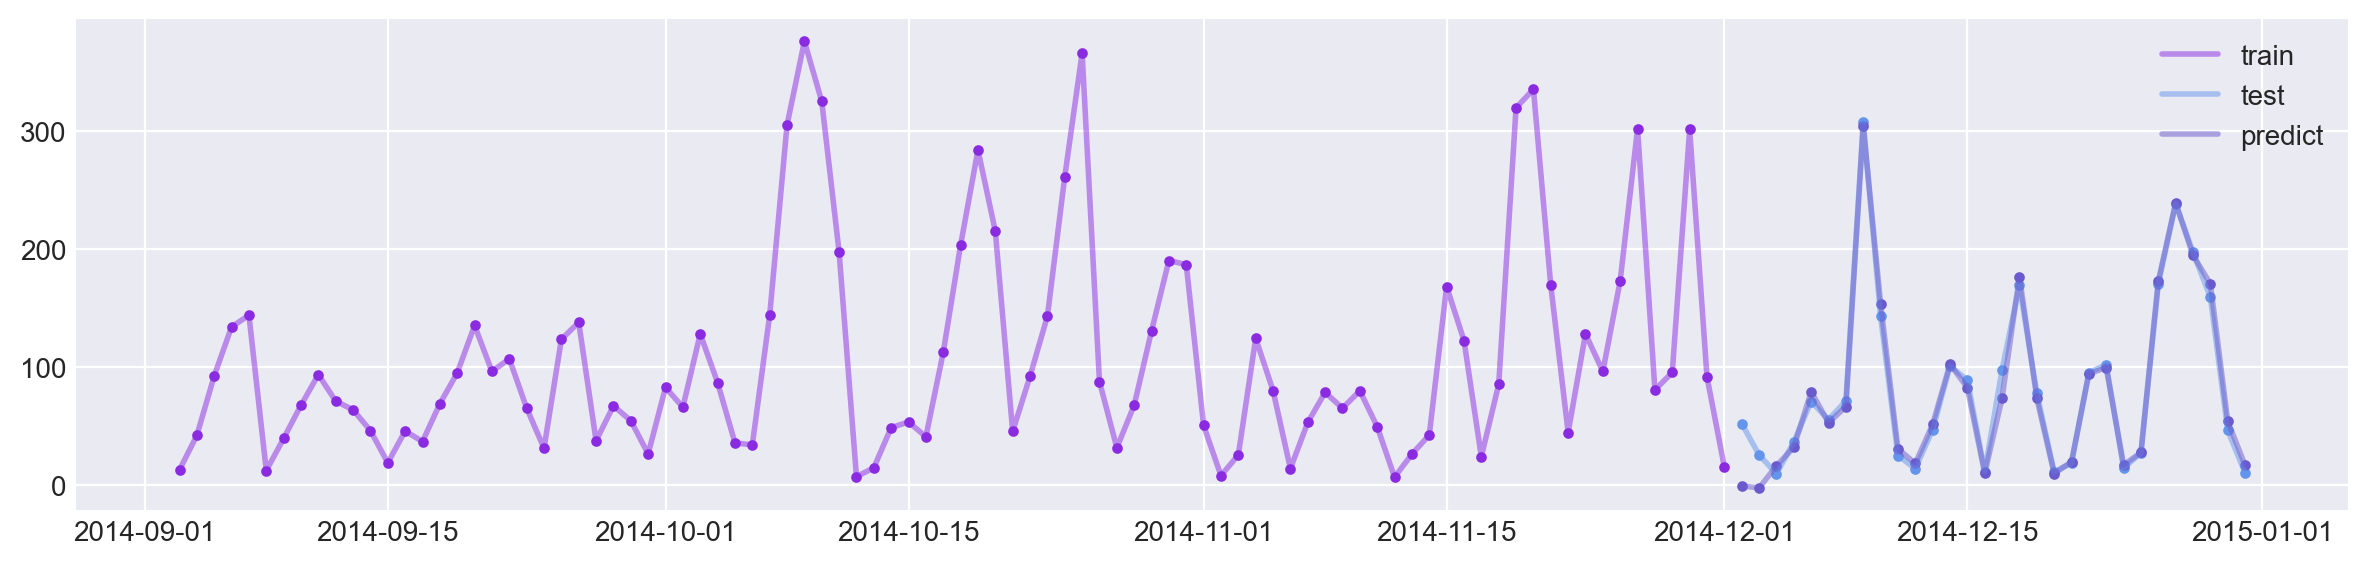

In [24]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [25]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [26]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/15
200/200 [==============================] - 39s 90ms/step - loss: 4188.3706 - mae: 46.7667 - val_loss: 1551.9075 - val_mae: 29.3197
Epoch 2/15
200/200 [==============================] - 12s 60ms/step - loss: 541.0267 - mae: 16.6234 - val_loss: 237.7030 - val_mae: 12.2006
Epoch 3/15
200/200 [==============================] - 10s 49ms/step - loss: 132.1979 - mae: 8.9896 - val_loss: 64.2097 - val_mae: 5.6200
Epoch 4/15
200/200 [==============================] - 9s 43ms/step - loss: 70.5210 - mae: 6.4307 - val_loss: 163.3363 - val_mae: 11.3109
Epoch 5/15
200/200 [==============================] - 9s 46ms/step - loss: 53.0327 - mae: 5.5749 - val_loss: 47.7129 - val_mae: 4.8314
Epoch 6/15
200/200 [==============================] - 9s 46ms/step - loss: 41.2657 - mae: 5.0144 - val_loss: 67.7376 - val_mae: 5.9650
Epoch 7/15
200/200 [==============================] - 9s 44ms/step - loss: 35.5262 - mae: 4.6220 - val_loss: 51.5622 - val_mae: 5.0034
Epoch 8/15
200/200 [===================

In [28]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

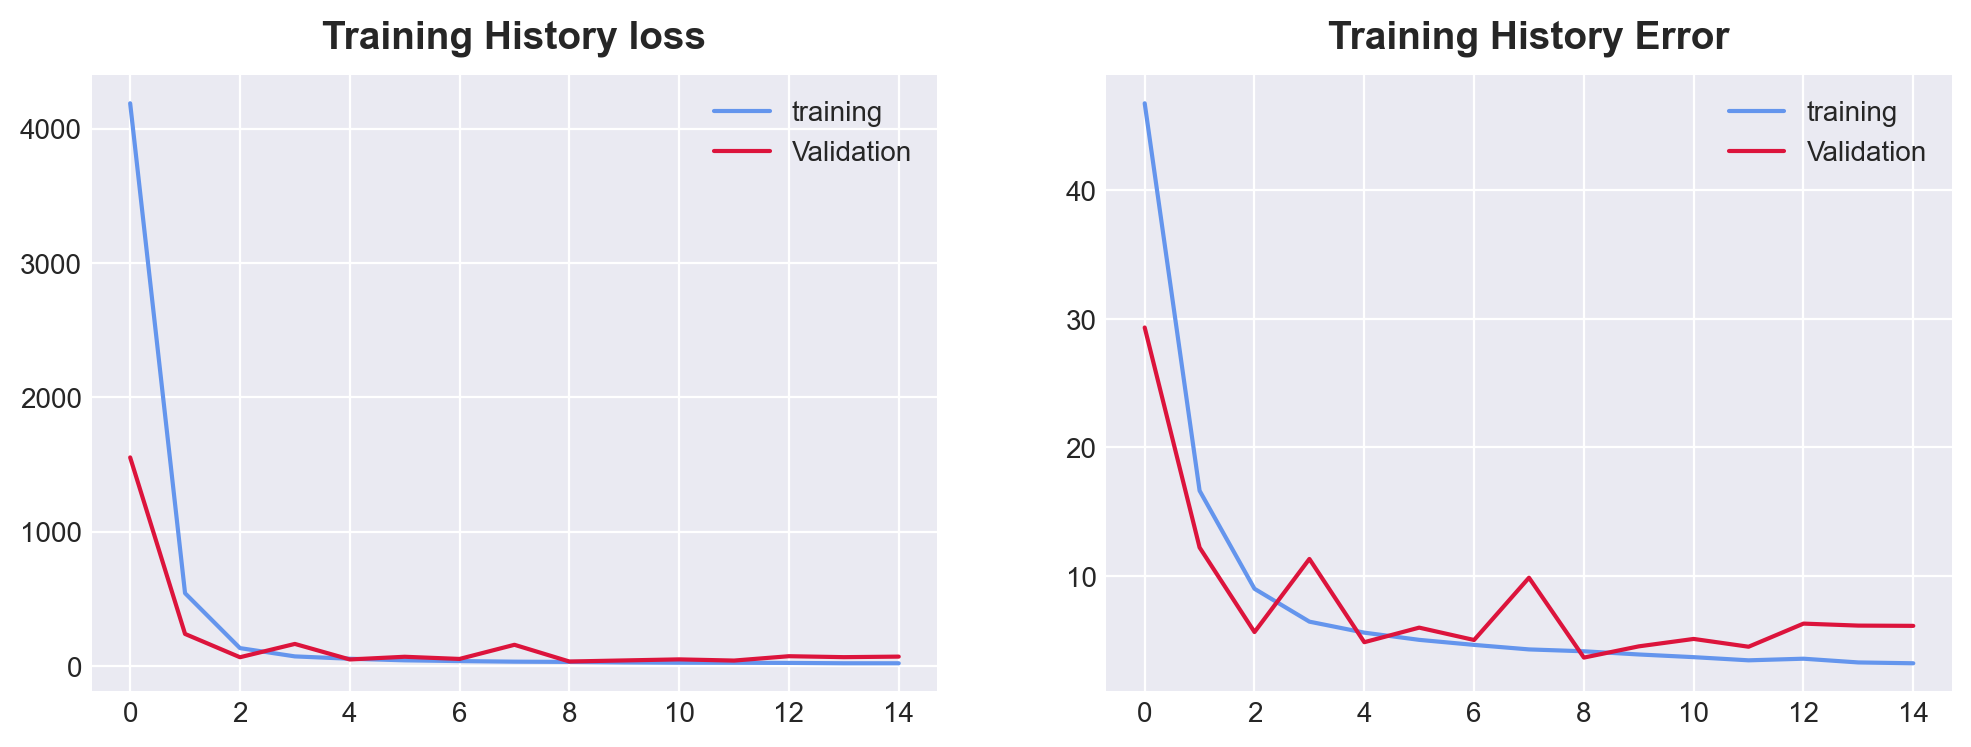

In [29]:
plot_tf_training_history(training_history)

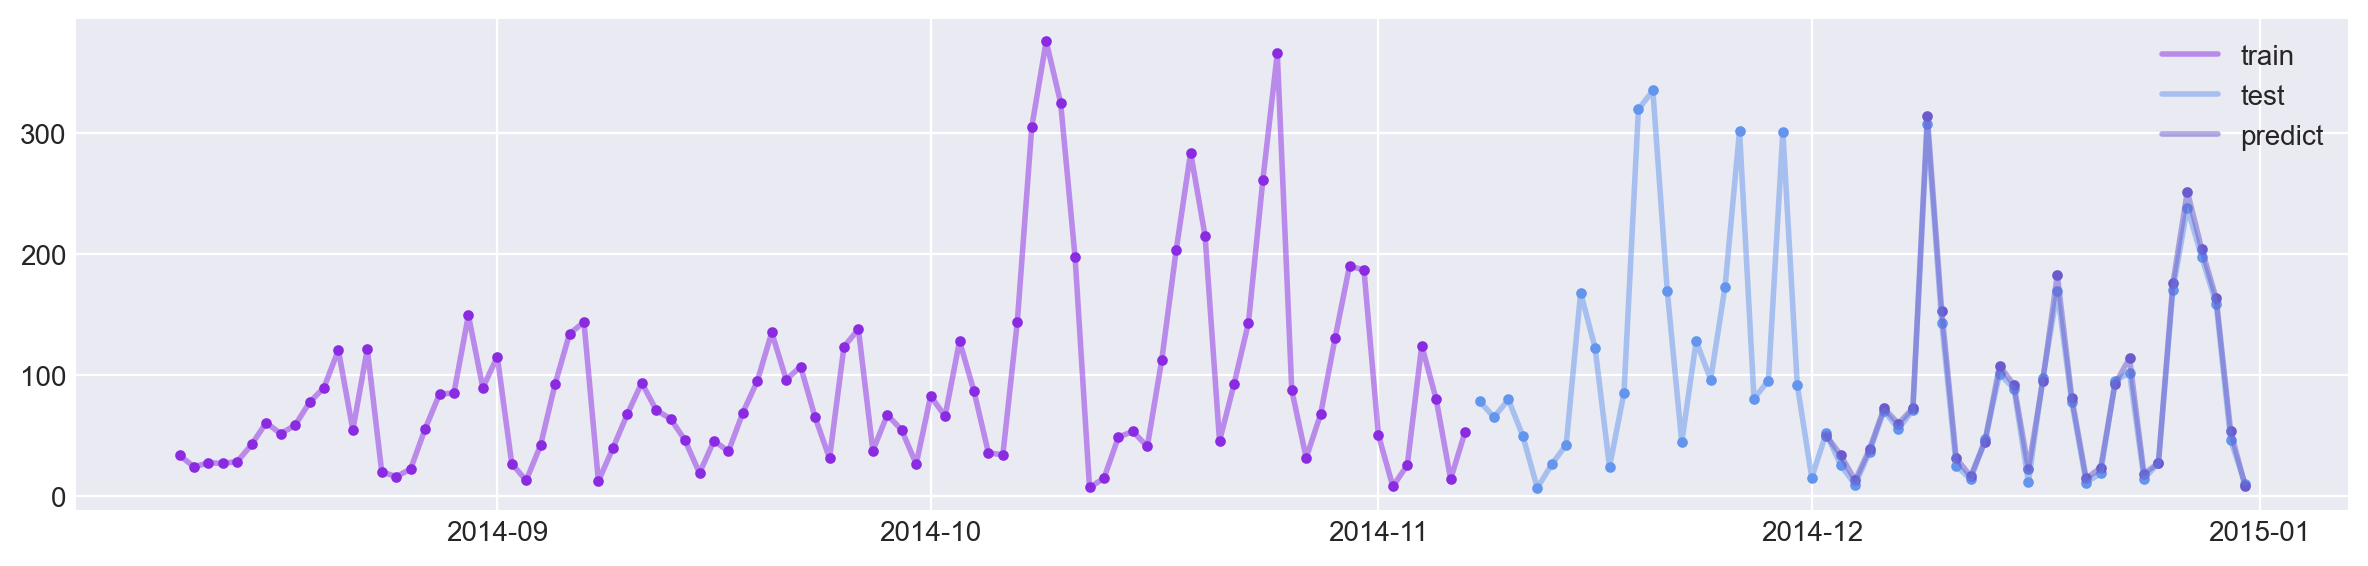

In [30]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [31]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,32.036411,3.719444,3.946330,11.206154,8.875182,9.261864,7.436213,6.103464
rmse,44.403010,14.803536,14.688406,16.627635,13.735031,13.374679,12.790585,8.295571
mape,0.928402,0.100347,0.106267,0.338688,0.241541,0.238536,0.195747,0.121899
r2,0.641355,0.960137,0.960754,0.949708,0.965684,0.967461,0.970241,0.991026


In [32]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,32.036411,44.403010,0.928402,0.641355
BayesianRidge,3.719444,14.803536,0.100347,0.960137
LassoCV,3.946330,14.688406,0.106267,0.960754
RandomForestRegressor,11.206154,16.627635,0.338688,0.949708
XGBRegressor,8.875182,13.735031,0.241541,0.965684
LGBMRegressor,9.261864,13.374679,0.238536,0.967461
CatBoostRegressor,7.436213,12.790585,0.195747,0.970241
LSTM_Dense,6.103464,8.295571,0.121899,0.991026


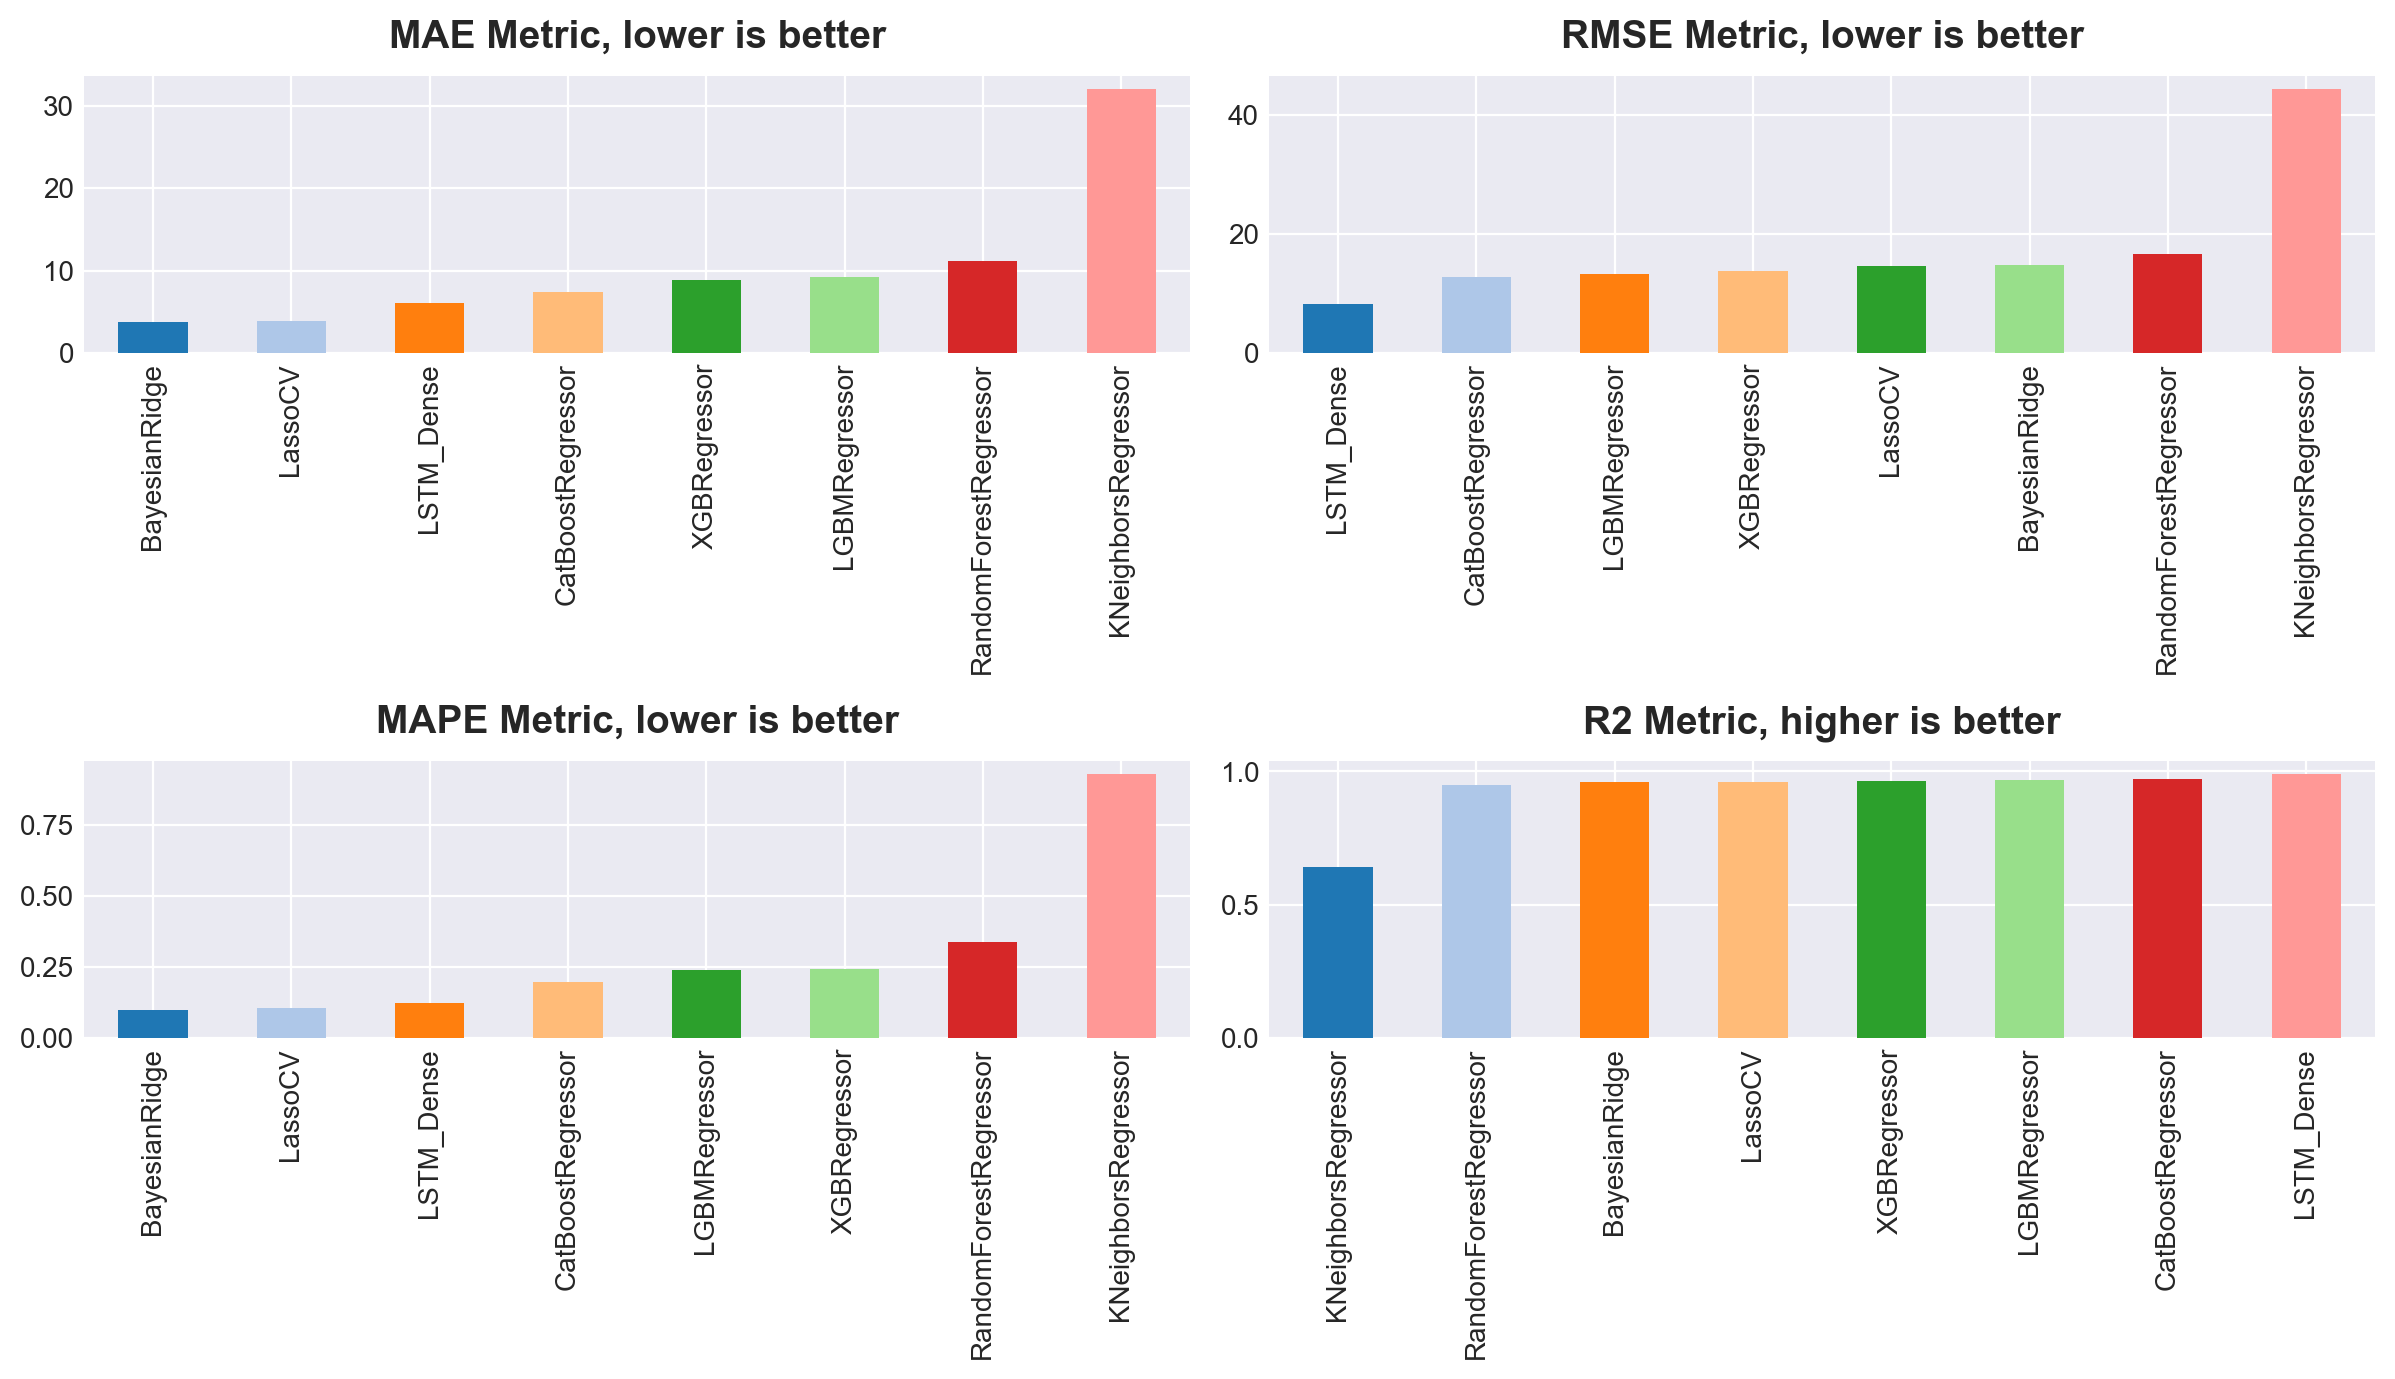

In [33]:
plot_metrics(resultsDF)

In [34]:
resultsDF.T["dataset"] = "air_polution"
resultsDF.T["Mode"] = "Singel_step"

resultsDF.T.to_csv("./air_polution_results.csv", index=False)